In [2]:
# setting up all of the packages
!pip install -q optuna

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import torch
import torch.nn as nn
import optuna
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

# raster and dataframe handling packages
import rasterio
import rioxarray as rio

# stats packages
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler

# print(os.getcwd())
# custom functions from class LEAP env.
from utils import * 

# plotting parameters
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

# Preparing our predictor and predictand data
predictor: (X, TerraClim climate variables), predictant: (Y, MODIS LAI) data

In [3]:
# establish path and open our merged and masked climate and LAI data as an array
# path = "/home/jovyan/large_files/climLai_masked_v3.nc"
path = "/home/jovyan/large_files/climLai_masked_anom.nc"
ds_combined = xr.open_dataset(path)

In [4]:
# Count NaNs per variable, these should all match!
for var in ds_combined.data_vars:
    print(var, ds_combined[var].isnull().sum().item())

tmmx 598044
tmmn 598044
pr 598044
pdsi 598044
def 598044
vpd 598044
soil 598044
lai 598044


<xarray.Dataset> Size: 77MB
Dimensions:      (time: 228, lat: 71, lon: 74)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat          (lat) float32 284B -9.825 -9.875 -9.925 ... -13.28 -13.33
  * lon          (lon) float32 296B -72.38 -72.32 -72.28 ... -68.78 -68.72
    spatial_ref  (time) int64 2kB ...
    month        (time) int64 2kB ...
Data variables:
    tmmx         (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    tmmn         (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    pr           (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    pdsi         (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    def          (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    vpd          (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    soil         (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    lai          (time, lat, lon) flo

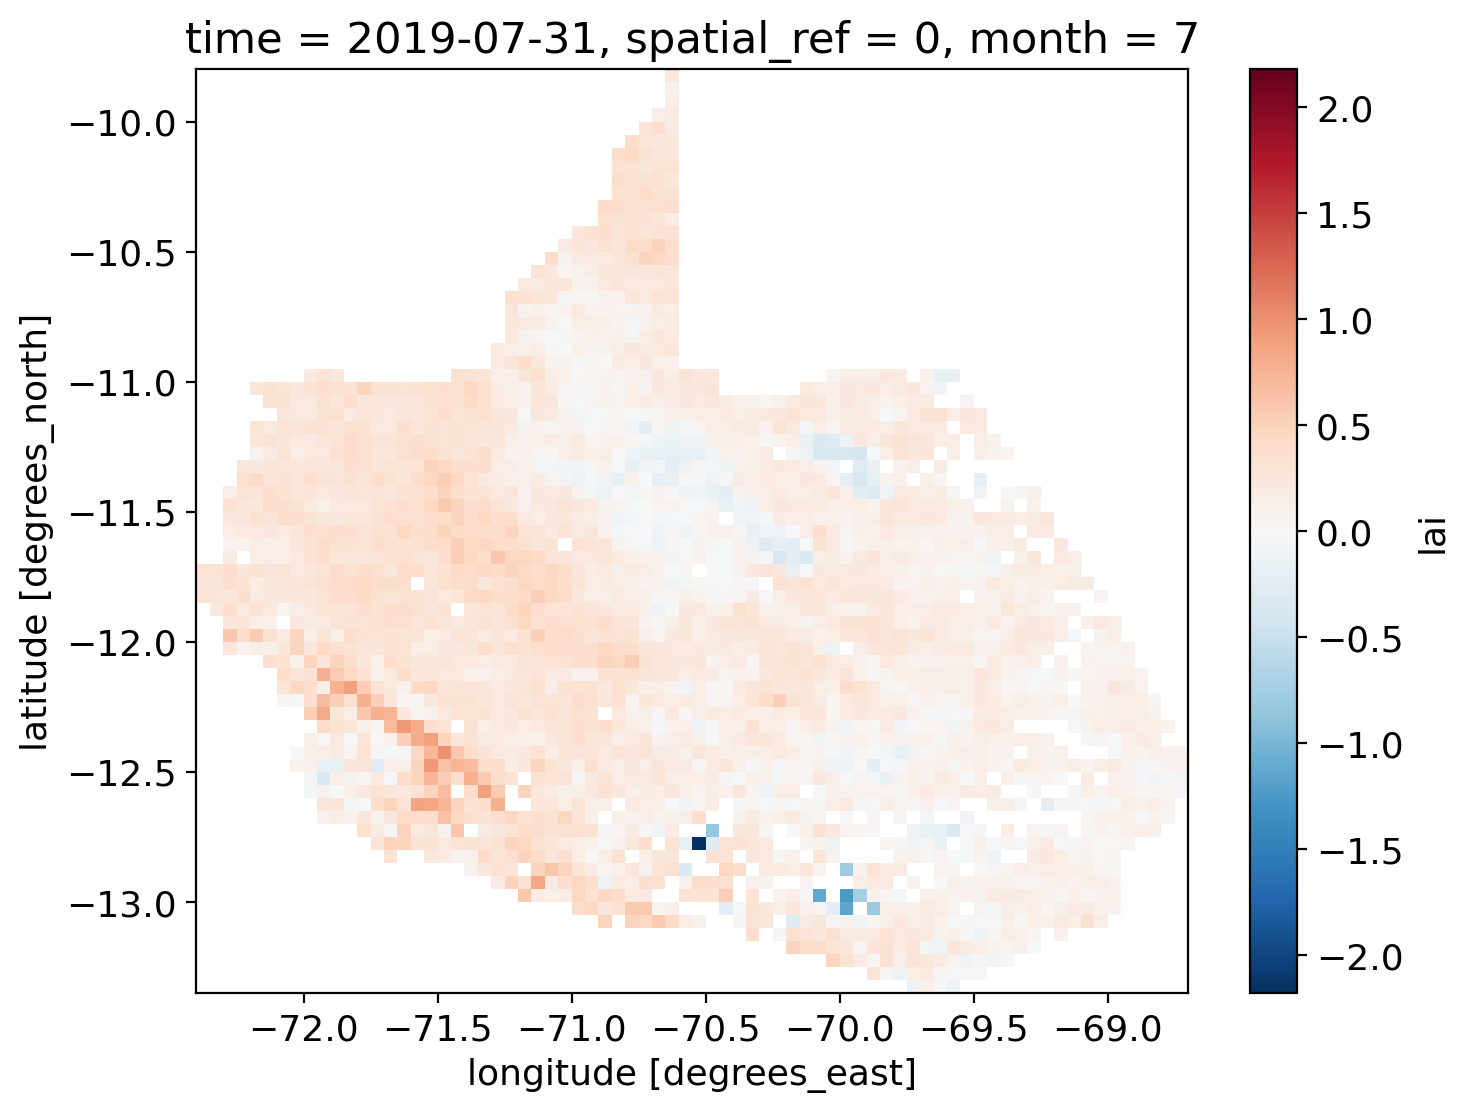

In [5]:
# take a look and map at the ds_combined dataset, this should only cover the political extent of Madre de Dios
print(ds_combined)
ds_combined.lai.isel(time=210).plot(figsize=(8,6))

In [6]:
# the data array has 3 dimensions (time, lat, lon). Stack the coordinate values to go from 3d to 2d.
ds_stacked = ds_combined.stack(stacked=("lat", "lon"))

In [7]:
# convert to data frame for later processing. Time, lat, lon become indexes.
df_combined = ds_stacked.to_dataframe().dropna()
print(df_combined)

                                      tmmx      tmmn          pr      pdsi  \
time       lat        lon                                                    
2002-01-31 -9.825002  -70.625000  0.710526  0.610526  127.473684  6.951053   
           -9.875002  -70.625000  0.663158  0.657895  118.894737  7.005263   
           -9.925001  -70.625000  0.642105  0.626316  114.736842  6.954737   
           -9.975001  -70.674995  0.678947  0.642105  108.000000  6.787368   
                      -70.625000  0.626316  0.621053  110.473684  6.945263   
...                                    ...       ...         ...       ...   
2020-12-31 -13.275002 -69.474998  0.763158  0.589474  104.684211 -2.172632   
           -13.325002 -69.724998  0.784211  0.642105  103.894737 -0.917368   
                      -69.674995  0.800000  0.626316  104.526316 -0.950000   
                      -69.625000  0.763158  0.657895  106.368421 -1.386316   
                      -69.574997  0.800000  0.610526  107.631579

In [8]:
# from dataframe generate the x_df (ONLY climate predictor variables, drop the lai column)
x_df = df_combined.drop(columns=["lai","spatial_ref"])

# look at x_df, make sure it looks ok!
x_df.head()

tmmx      tmmn          pr      pdsi  \
time       lat       lon                                                    
2002-01-31 -9.825002 -70.625000  0.710526  0.610526  127.473684  6.951053   
           -9.875002 -70.625000  0.663158  0.657895  118.894737  7.005263   
           -9.925001 -70.625000  0.642105  0.626316  114.736842  6.954737   
           -9.975001 -70.674995  0.678947  0.642105  108.000000  6.787368   
                     -70.625000  0.626316  0.621053  110.473684  6.945263   

                                 def       vpd          soil  month  
time       lat       lon                                             
2002-01-31 -9.825002 -70.625000  0.0  0.092632  5.684342e-14      1  
           -9.875002 -70.625000  0.0  0.092632 -5.684342e-14      1  
           -9.925001 -70.625000  0.0  0.090526  0.000000e+00      1  
           -9.975001 -70.674995  0.0  0.099474 -5.684342e-14      1  
                     -70.625000  0.0  0.096842  5.684342e-14      1

In [9]:
# from dataframe generate y_df (ONLY lai)
y_df = df_combined.drop(columns=["spatial_ref",
                                 "tmmx",
                                 "tmmn",
                                 "pr",
                                 "pdsi",
                                 "def",
                                 "vpd",
                                 "soil"])

# look at y_df, make sure it looks ok!
y_df.head()

lai  month
time       lat       lon                        
2002-01-31 -9.825002 -70.625000  0.657735      1
           -9.875002 -70.625000  0.193407      1
           -9.925001 -70.625000  0.175278      1
           -9.975001 -70.674995  0.773132      1
                     -70.625000  0.000997      1

## Split our data into training, validation and testing and normalize
Look at the entire time sequence of our data: 19 years, 12 months per year
(19yrs x 12months) = 228 time steps

We want the last two years to be our testing dataset: 2019 and 2020
Therefore, the first 17 tears are our training and validation data
Of this, 80% must be training (14 years), 20% must be validation (3 years)

So the final break-down is:
Training: 2002-2015 (14yrs x 12months = 168 ts)
Validation: 2016-2018 (3yrs x 12months = 36 ts)
Testing: 2019-2020 (2yrs x 12months = 24 ts)

In [10]:
# CHANGED

# 1 - set hyperparameters
n_neuron       = 128
num_layers     = 2
num_epochs     = 30
learning_rate  = 0.00001
minibatch_size = 64 #CHECK
model_version  = "8_1_nn128_n2_e30"
lookback       = 18

train_yr_start = 2007
val_yr_start = 2017
test_yr_start = 2019
test_yr_end = 2020

In [11]:
# look at the entire time sequence of our data
first_time = x_df.index.get_level_values("time")[0]
last_time  = x_df.index.get_level_values("time")[-1]

print('time 0 =', first_time)
print('time last =', last_time)

time 0 = 2002-01-31 00:00:00
time last = 2020-12-31 00:00:00


In [12]:
# -----------------------------
# 1. Define time boundaries
# -----------------------------
train_start = f"{train_yr_start}-01-31"        # 2003-01-31
val_start   = f"{val_yr_start}-01-31"          # 2013-01-31
test_start  = f"{test_yr_start}-01-31"         # 2015-01-31
test_end    = f"{test_yr_end + 1}-01-31"       # exclusive

times = x_df.index.get_level_values("time")

# -----------------------------
# 2. Split data by time
# -----------------------------
# Train
x_df_train = x_df.loc[(times >= train_start) & (times < val_start)]
y_df_train = y_df.loc[(times >= train_start) & (times < val_start)]

# Validation
x_df_valid = x_df.loc[(times >= val_start) & (times < test_start)]
y_df_valid = y_df.loc[(times >= val_start) & (times < test_start)]

# Test
x_df_test = x_df.loc[(times >= test_start) & (times < test_end)]
y_df_test = y_df.loc[(times >= test_start) & (times < test_end)]

# -----------------------------
# 3. Min–max standardization (fit on TRAIN only)
# -----------------------------
feature_cols = ["tmmx", "tmmn", "pr", "pdsi", "def", "vpd", "soil"]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x_df_train[feature_cols])

x_df_train[feature_cols] = scaler.transform(x_df_train[feature_cols])
x_df_valid[feature_cols]   = scaler.transform(x_df_valid[feature_cols])
x_df_test[feature_cols]  = scaler.transform(x_df_test[feature_cols])

# -----------------------------
# 4. Sanity checks
# -----------------------------
print("train:", x_df_train.index.get_level_values("time")[0],
      "→", x_df_train.index.get_level_values("time")[-1])

print("val  :", x_df_valid.index.get_level_values("time")[0],
      "→", x_df_valid.index.get_level_values("time")[-1])

print("test :", x_df_test.index.get_level_values("time")[0],
      "→", x_df_test.index.get_level_values("time")[-1])

train: 2007-01-31 00:00:00 → 2016-12-31 00:00:00
val  : 2017-01-31 00:00:00 → 2018-12-31 00:00:00
test : 2019-01-31 00:00:00 → 2020-12-31 00:00:00


/tmp/ipykernel_750/2440377596.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_train[feature_cols] = scaler.transform(x_df_train[feature_cols])
/tmp/ipykernel_750/2440377596.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_valid[feature_cols]   = scaler.transform(x_df_valid[feature_cols])
/tmp/ipykernel_750/2440377596.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [13]:
# test to make sure the splits worked:
print('shape x_df_train', x_df_train.shape)
print('shape x_df_valid', x_df_valid.shape)
print('shape x_df_test', x_df_test.shape)

print('shape y_df_train', y_df_train.shape)
print('shape y_df_valid', y_df_valid.shape)
print('shape y_df_test', y_df_test.shape)

print(lookback)

shape x_df_train (315720, 8)
shape x_df_valid (63144, 8)
shape x_df_test (63144, 8)
shape y_df_train (315720, 2)
shape y_df_valid (63144, 2)
shape y_df_test (63144, 2)
18


In [14]:
# look at some summary statistics to check the normalization
train_stats = x_df_train[feature_cols].agg(['mean','std','min','max']).T
valid_stats = x_df_valid[feature_cols].agg(['mean','std','min','max']).T
test_stats = x_df_test[feature_cols].agg(['mean','std','min','max']).T

# let's check our standardization
print("Training data\n", train_stats)
print("Validation data\n", valid_stats)
print("Testing data\n", test_stats)

Training data
           mean       std  min  max
tmmx  0.438878  0.139326  0.0  1.0
tmmn  0.549120  0.141171  0.0  1.0
pr    0.290508  0.083127  0.0  1.0
pdsi  0.376004  0.185745  0.0  1.0
def   0.402808  0.080495  0.0  1.0
vpd   0.441452  0.097692  0.0  1.0
soil  0.491436  0.093186  0.0  1.0
Validation data
           mean       std       min       max
tmmx  0.458900  0.125494  0.023981  0.705036
tmmn  0.498183  0.114841  0.096288  0.742459
pr    0.286865  0.045139  0.129996  0.438341
pdsi  0.396298  0.116944  0.148972  0.684806
def   0.379658  0.065730  0.093127  0.550151
vpd   0.418045  0.171071 -0.094779  0.926104
soil  0.512929  0.084292  0.259919  0.950208
Testing data
           mean       std       min       max
tmmx  0.668939  0.149899  0.342926  1.236211
tmmn  0.695585  0.161995  0.367749  1.313225
pr    0.298958  0.076480  0.098105  0.803272
pdsi  0.411420  0.162964 -0.036910  0.996860
def   0.418290  0.071406  0.097288  0.871478
vpd   0.734871  0.247218  0.222490  1.734940

In [15]:
# # ds = x_df_train   # your dataset

# vars_to_plot = ["tmmx","tmmn","pr","pdsi","def","vpd","soil"]

# fig, axes = plt.subplots(2, 4, figsize=(18, 9))
# axes = axes.ravel()

# for ax, var in zip(axes, vars_to_plot):
#     data = x_df_train[var].values.flatten()
#     data = data[~np.isnan(data)]
#     ax.hist(data, bins=50)
#     ax.set_title(var)
# plt.tight_layout()
# plt.show()

# vars_to_plot = ["tmmx","tmmn","pr","pdsi","def","vpd","soil"]

# fig, axes = plt.subplots(2, 4, figsize=(18, 9))
# axes = axes.ravel()

# for ax, var in zip(axes, vars_to_plot):
#     data = x_df_test[var].values.flatten()
#     data = data[~np.isnan(data)]
#     ax.hist(data, bins=50, color='red')
#     ax.set_title(var)
# plt.tight_layout()
# plt.show()

# vars_to_plot = ["tmmx","tmmn","pr","pdsi","def","vpd","soil"]

# fig, axes = plt.subplots(2, 4, figsize=(18, 9))
# axes = axes.ravel()

# for ax, var in zip(axes, vars_to_plot):
#     data = x_df_valid[var].values.flatten()
#     data = data[~np.isnan(data)]
#     ax.hist(data, bins=50, color='orange')
#     ax.set_title(var)

# plt.tight_layout()
# plt.show()

## Reshape data to feed into the LSTM model
0) Make time a column (not index) in our data
1) Merge predictors and predictands
2) Scale the climate inputs.
   Training data will be normalized to mean=0, std=1, Validation data will be scaled with those meands and std
3) Create the look-back window per pixel!
4) Convert to PyTorch datasets
5) Create the Data Loaders, shuffle=False

In [16]:
# 0 - Ensure Time is a column of our data
# Time is currently an INDEX not a column of our data, we need to convert it into a COLUMN
def ensure_time_column(df):
    if "time" not in df.columns:
        # index must be time
        df = df.reset_index().rename(columns={"index": "time"})
    df["time"] = pd.to_datetime(df["time"])
    return df

In [17]:
# 1 - Merge the X (predictors, climate variables) and Y (predictands, modis lai) datasets
def merge_xy(x_df, y_df):
    x_df = ensure_time_column(x_df)
    y_df = ensure_time_column(y_df)
    
    df = x_df.merge(y_df, on=["time", "lat", "lon"], how="inner")
    df = df.sort_values(["lat", "lon", "time"]).reset_index(drop=True)
    return df

train_df = merge_xy(x_df_train, y_df_train)
valid_df = merge_xy(x_df_valid, y_df_valid)
# adding the test data to this nonsense
test_df = merge_xy(x_df_test, y_df_test)

print(test_df)

print(len(train_df))
print(len(valid_df))
print(len(test_df))

print(315720+63144)

            time        lat        lon      tmmx      tmmn        pr  \
0     2019-01-31 -13.325002 -69.724998  0.641487  0.603248  0.397339   
1     2019-02-28 -13.325002 -69.724998  0.670264  0.595128  0.362031   
2     2019-03-31 -13.325002 -69.724998  0.700240  0.706497  0.229188   
3     2019-04-30 -13.325002 -69.724998  0.625899  0.733179  0.361721   
4     2019-05-31 -13.325002 -69.724998  0.751799  0.678654  0.351315   
...          ...        ...        ...       ...       ...       ...   
63139 2020-08-31  -9.825002 -70.625000  0.557554  0.625290  0.261855   
63140 2020-09-30  -9.825002 -70.625000  0.731415  0.805104  0.282667   
63141 2020-10-31  -9.825002 -70.625000  0.707434  0.736659  0.240215   
63142 2020-11-30  -9.825002 -70.625000  0.792566  0.858469  0.254763   
63143 2020-12-31  -9.825002 -70.625000  0.525180  0.590487  0.321443   

           pdsi       def       vpd      soil  month_x       lai  month_y  
0      0.564398  0.404219  0.578313  0.486042        1  0.2

In [18]:
# 3 - build the lstm sequences for each pixel, establish 3 timesteps (months) as our "look-back" window
# define sequence building function
def build_sequences(df, feature_cols, lookback):
    X_list, y_list, coords, times = [], [], [], []

    # for every lat, lon combination in grouping by lat,lon (pixel)
    for (lat, lon), group in df.groupby(["lat", "lon"]):
        group = group.sort_values("time") #sort by values of time, each time instance is 1 month

        X_vals = group[feature_cols].values #for x, get values of predictors (defined by all feature cols)
        y_vals = group["lai"].values #for y, get values of lai, predictant
        t_vals = group["time"].values

        # for every instance in the length of the entire time sequence minus the lookback window
        for i in range(len(group) - lookback): 
            # the instances in lookback window predict 1 timestep after lookback window, last three months predict the fourth, etc.
            X_list.append(X_vals[i:i+lookback]) # append all the x values in index of instance start to end of instance (length of window)
            y_list.append(y_vals[i+lookback]) # append value that is in place of start of instance + length of lookback window
            coords.append((lat, lon))
            times.append(t_vals[i+lookback])

    return (
        np.array(X_list, dtype=np.float32),
        np.array(y_list, dtype=np.float32),
        coords,
        np.array(times, dtype="datetime64[ns]")
    )

# lookback = 22 # will use the past 6 months (time-steps of data) to get the next 7th month

# apply the function
X_train_np, y_train_np, train_coords, train_times = build_sequences(train_df, feature_cols, lookback)
X_valid_np, y_valid_np, valid_coords, valid_times = build_sequences(valid_df, feature_cols, lookback)
# CHANGED!!!!!!
X_test_np, y_test_np, test_coords, test_times = build_sequences(test_df, feature_cols, lookback)

print("Train X shape:", X_train_np.shape) # (len_t), lookback, feat
print("Valid X shape:", X_valid_np.shape) # (len_v), lookback, feat
print("Test X shape:", X_test_np.shape) # (len_v), lookback, feat
print("Test Y shape:", y_test_np.shape)

print(len(test_times))
print(test_times)


# Train X shape and Valid X shape should have the same lookback and features (the last two values)
# BUT should differ in their first dimension, with Train beging larger reflecting there is a greater ammount of data going into training

Train X shape: (268362, 18, 7)
Valid X shape: (15786, 18, 7)
Test X shape: (15786, 18, 7)
Test Y shape: (15786,)
15786
['2020-07-31T00:00:00.000000000' '2020-08-31T00:00:00.000000000'
 '2020-09-30T00:00:00.000000000' ... '2020-10-31T00:00:00.000000000'
 '2020-11-30T00:00:00.000000000' '2020-12-31T00:00:00.000000000']


In [19]:
# 4 - convert to PYTORCH dataset, ready for model ingestion

# before conversion, check for NaNs again. Model will not work if NaNs are present.
np.isnan(X_valid_np).any(), np.isnan(y_valid_np).any(), np.isnan(X_test_np).any()

# define the pytorch conversion function
class ClimateLAIDataset(Dataset):
    def __init__(self, X, y, coords):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.coords = coords

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ClimateLAIDataset(X_train_np, y_train_np, train_coords)
valid_dataset = ClimateLAIDataset(X_valid_np, y_valid_np, valid_coords)
test_dataset = ClimateLAIDataset(X_test_np, y_test_np, test_coords)

print(test_dataset)

In [20]:
# 5 - DATALOADERS, both should be shuffle=false because this is time series data! we want the chronological order
train_loader = DataLoader(train_dataset, batch_size=minibatch_size, shuffle=False, drop_last=False)
val_loader = DataLoader(valid_dataset, batch_size=minibatch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False, drop_last=False)
sens_loader = DataLoader(
    test_dataset,
    batch_size=minibatch_size*10,
    shuffle=True,
    drop_last=False
)
print(test_loader)

## Define LSTM structure
1) set the model hyperparameters
2) define the model
3) define optimizer (ADAM) and evaluation criteria (MSE of loss)

In [21]:
# CHANGED

# 2 - define the model

# device definition, make sure model is running on GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model definition
import torch.nn as nn

# class LAI_LSTM(nn.Module):
#     def __init__(self, num_features=7, hidden_size=64, num_layers=1):
#         super(LAI_LSTM, self).__init__()

#         self.lstm = nn.LSTM(
#             input_size=num_features,
#             hidden_size=hidden_size,
#             num_layers=num_layers,
#             batch_first=True
#         )
#         self.fc = nn.Linear(hidden_size, 1)

#     def forward(self, x):

#         # Run LSTM
#         output, (h_n, c_n) = self.lstm(x)
#         # Fully connected layer on last hidden state
#         out = self.fc(h_n[-1])

#         # Squeeze last dimension only
#         out = out.squeeze(1)

#         return out

class InputAttention(nn.Module):
    """
    Feature-level attention (which input variables matter at each timestep)
    """
    def __init__(self, input_dim, hidden_dim):
        super(InputAttention, self).__init__()
        self.attn = nn.Linear(hidden_dim + input_dim, input_dim)

    def forward(self, x_t, h_prev):
        # x_t: [batch, input_dim]
        # h_prev: [batch, hidden_dim]

        combined = torch.cat((x_t, h_prev), dim=1)
        scores = self.attn(combined)                   # [batch, input_dim]
        weights = F.softmax(scores, dim=1)             # feature-level attention
        x_tilde = weights * x_t                        # element-wise weighting

        return x_tilde, weights


class TemporalAttention(nn.Module):
    """
    Time-step attention (which timesteps matter most)
    """
    def __init__(self, hidden_dim):
        super(TemporalAttention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, encoder_outputs):
        # encoder_outputs: [batch, seq_len, hidden_dim]

        scores = self.attn(encoder_outputs)            # [batch, seq_len, 1]
        weights = F.softmax(scores, dim=1)             # time-level attention
        context = torch.sum(weights * encoder_outputs, dim=1)

        return context, weights


class DA_RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=num_layers):
        super(DA_RNN, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM cell for stepwise encoding
        self.encoder_lstm = nn.LSTMCell(input_dim, hidden_dim)

        # Attention blocks
        self.input_attention = InputAttention(input_dim, hidden_dim)
        self.temporal_attention = TemporalAttention(hidden_dim)

        # Output layer
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        batch_size, seq_len, input_dim = x.size()

        h_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)

        encoder_outputs = []

        # ----- Encoder with feature-level attention -----
        for t in range(seq_len):
            x_t = x[:, t, :]                                  # [batch, input_dim]

            # Feature-level attention
            x_tilde, feature_weights = self.input_attention(x_t, h_t)

            # LSTM step
            h_t, c_t = self.encoder_lstm(x_tilde, (h_t, c_t))

            encoder_outputs.append(h_t.unsqueeze(1))

        encoder_outputs = torch.cat(encoder_outputs, dim=1)   # [batch, seq_len, hidden_dim]

        # ----- Temporal (time-level) attention -----
        context, time_weights = self.temporal_attention(encoder_outputs)

        # ----- Final prediction -----
        out = self.fc(context)                                # [batch, 1]
        out = out.squeeze(1)

        return out, feature_weights, time_weights

model = DA_RNN(input_dim=len(feature_cols), 
               hidden_dim=n_neuron, 
               num_layers=num_layers)
model.to(device)
print("DA-RNN ready")

DA-RNN ready


In [22]:
# CHANGED

# 3 - define the optimizer (ADAM), and the evaluation criterion: MSELoss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()

## Training and saving the model

In [23]:
# # CHANGED

# from utils import pytorch_train2
# train_losses_mse, val_losses_mse = pytorch_train2(model, optimizer, 
#                                                   criterion = criterion, 
#                                                   device = device, 
#                                                   train_loader = train_loader, 
#                                                   val_loader = val_loader, 
#                                                   num_epochs = num_epochs)

In [24]:
# import itertools

# neurons = [32, 64, 128]
# layers = [1, 2, 3]

# results = []

# for hidden_dim, num_layers in itertools.product(neurons, layers):
#     model = DA_RNN(input_dim=len(feature_cols),
#                    hidden_dim=hidden_dim,
#                    num_layers=num_layers).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
#     # Train for only a few epochs on small subset
#     train_losses, val_losses = pytorch_train(model, optimizer, criterion, 
#                                              device, num_epochs=20, 
#                                              train_loader=train_loader, 
#                                              val_loader=val_loader)
    
#     results.append((hidden_dim, num_layers, train_losses[-1], val_losses[-1]))
#     print(f"hidden_dim={hidden_dim}, layers={num_layers}, "
#           f"train_loss={train_losses[-1]:.4f}, val_loss={val_losses[-1]:.4f}")


In [25]:
# looking at our training and validation loss
# plot_history(train_losses_mse, val_losses_mse)

plt.figure()
plt.plot(train_losses_mse, 
         color="#3e4989", 
         linewidth=2.5,
         label="Training Loss")
plt.plot(val_losses_mse, 
         color="#addc30", 
         linewidth=2.5,
         label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.show()

NameError: name 'train_losses_mse' is not defined

<Figure size 640x480 with 0 Axes>

In [26]:
# # CHANGED

# # export and SAVE model
# model_path = f"/home/jovyan/MLEAEEE4000-DroughtAmazon2/model_outputs/v{model_version}/"
# make_dir(model_path)

# # Save the model weights to a pth file
# torch.save(
#     model.state_dict(),
#     os.path.join(
#         model_path,
#         f"lkb{lookback}_yr"
#         f"{train_yr_start % 100}{val_yr_start % 100}"
#         f"{test_yr_start % 100}{test_yr_end % 100}.pth"
#     )
# )
# print(model)

## Testing the Model

In [27]:
model_path = f"/home/jovyan/MLEAEEE4000-DroughtAmazon2/model_outputs/v{model_version}/"

# make new model instance
model_eval = DA_RNN(input_dim=len(feature_cols), hidden_dim=n_neuron, num_layers=num_layers)

# construct the path to the saved weights
weights_path = os.path.join(
    model_path,
    f"lkb{lookback}_yr"
    f"{train_yr_start % 100}{val_yr_start % 100}"
    f"{test_yr_start % 100}{test_yr_end % 100}.pth"
)

print(weights_path)

# load the state dict from file
state_dict = torch.load(weights_path, map_location='cpu')  # or map_location='cuda' if needed

# print(state_dict)

# load weights into the model
model_eval.load_state_dict(state_dict)

# set model to eval mode if evaluating
model_eval.eval()

/home/jovyan/MLEAEEE4000-DroughtAmazon2/model_outputs/v8_1_nn128_n2_e30/lkb18_yr7171920.pth


DA_RNN(
  (encoder_lstm): LSTMCell(7, 128)
  (input_attention): InputAttention(
    (attn): Linear(in_features=135, out_features=7, bias=True)
  )
  (temporal_attention): TemporalAttention(
    (attn): Linear(in_features=128, out_features=1, bias=True)
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [28]:
# run model

model_eval.to(device).eval()
preds_list = []
targs_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:   # training loop unchanged
        X_batch = X_batch.to(device)
        outputs, feature_attn, time_attn = model_eval(X_batch)
        preds_list.append(outputs)
        targs_list.append(y_batch.cpu().numpy())

preds = np.concatenate(preds_list, axis=0)
targets = np.concatenate(targs_list, axis=0)

# Get coords from the dataset (must be in same order as samples)
coords = np.array(test_dataset.coords)   # shape (N_samples, 2) or similar

assert len(preds) == len(coords), "Order mismatch: ensure test_loader shuffle=False and drop_last=False"
print('all ok')

print(preds)
print(targets)
print(test_dataset)

all ok
[0.26722836 0.24040727 0.20567922 ... 0.11857215 0.13400833 0.15638983]
[0.13159512 0.10621133 0.05557363 ... 0.26239395 0.22743957 0.23827843]


## Sensitivity

[7.71506675e-05 1.06384345e-04 7.54042367e-06 3.35145342e-05
 1.86332054e-05 2.36272917e-05 3.28566712e-05]
[1.7155022e-05 1.9406414e-05 2.0457355e-05 2.0791511e-05 2.1859008e-05
 2.0683314e-05 2.0965692e-05 3.2217806e-05 4.4870918e-05 5.7021163e-05
 7.3691655e-05 8.4222178e-05 8.7432345e-05 8.1716360e-05 6.8718124e-05
 5.1113795e-05 3.2755652e-05 1.5597270e-05]


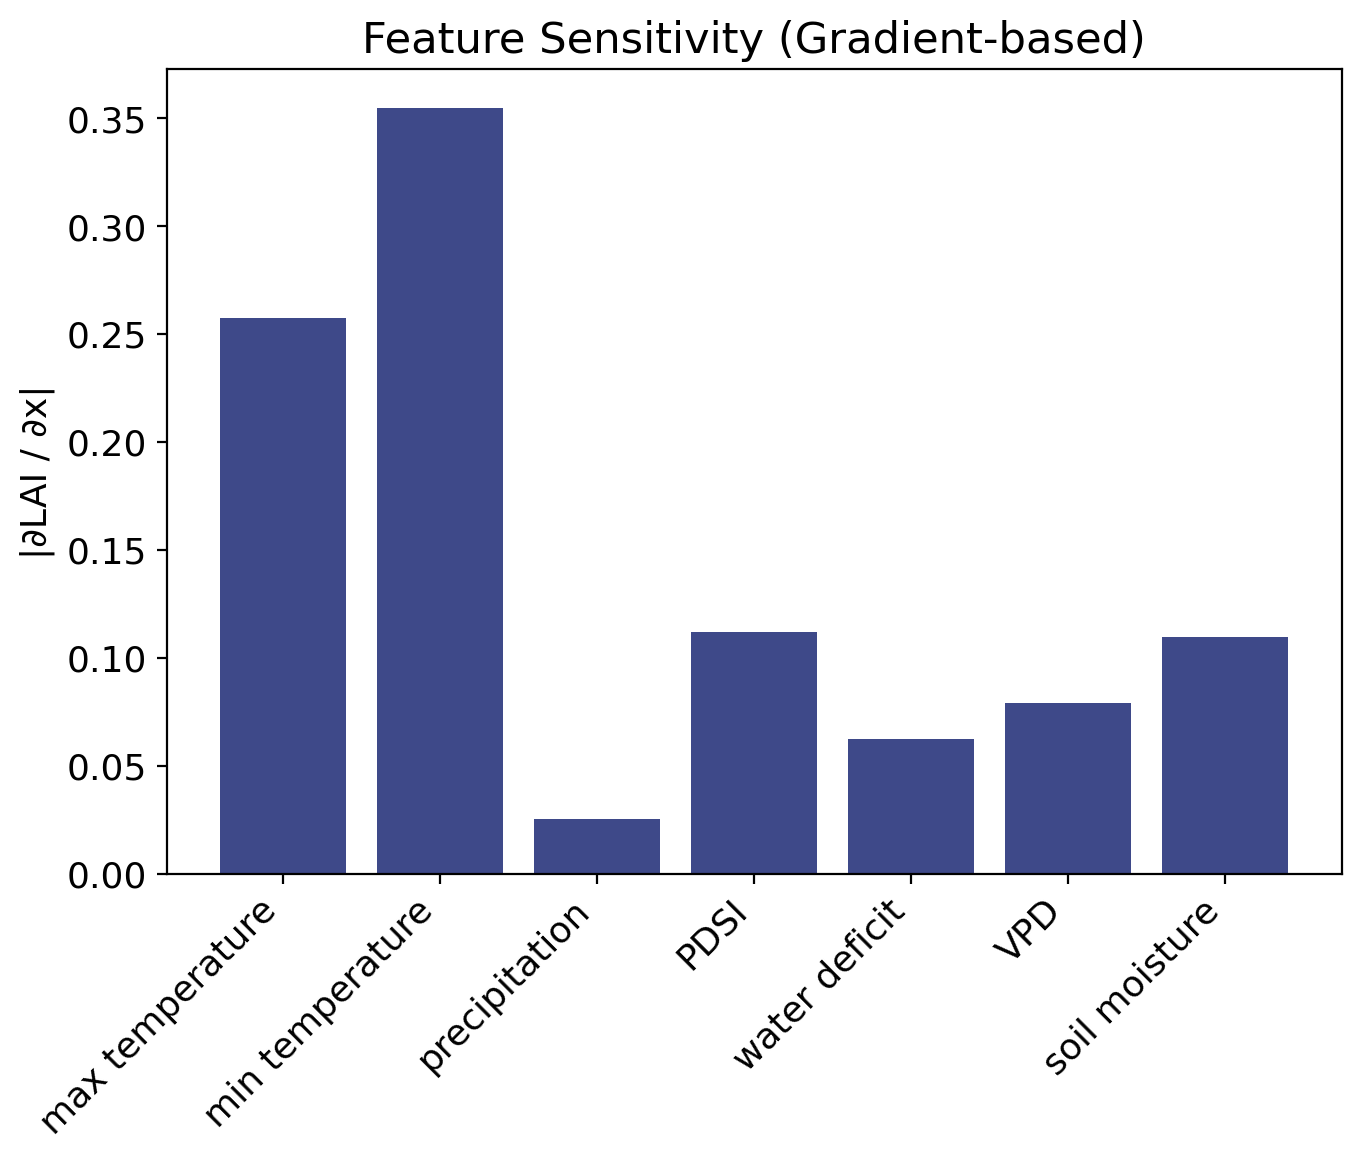

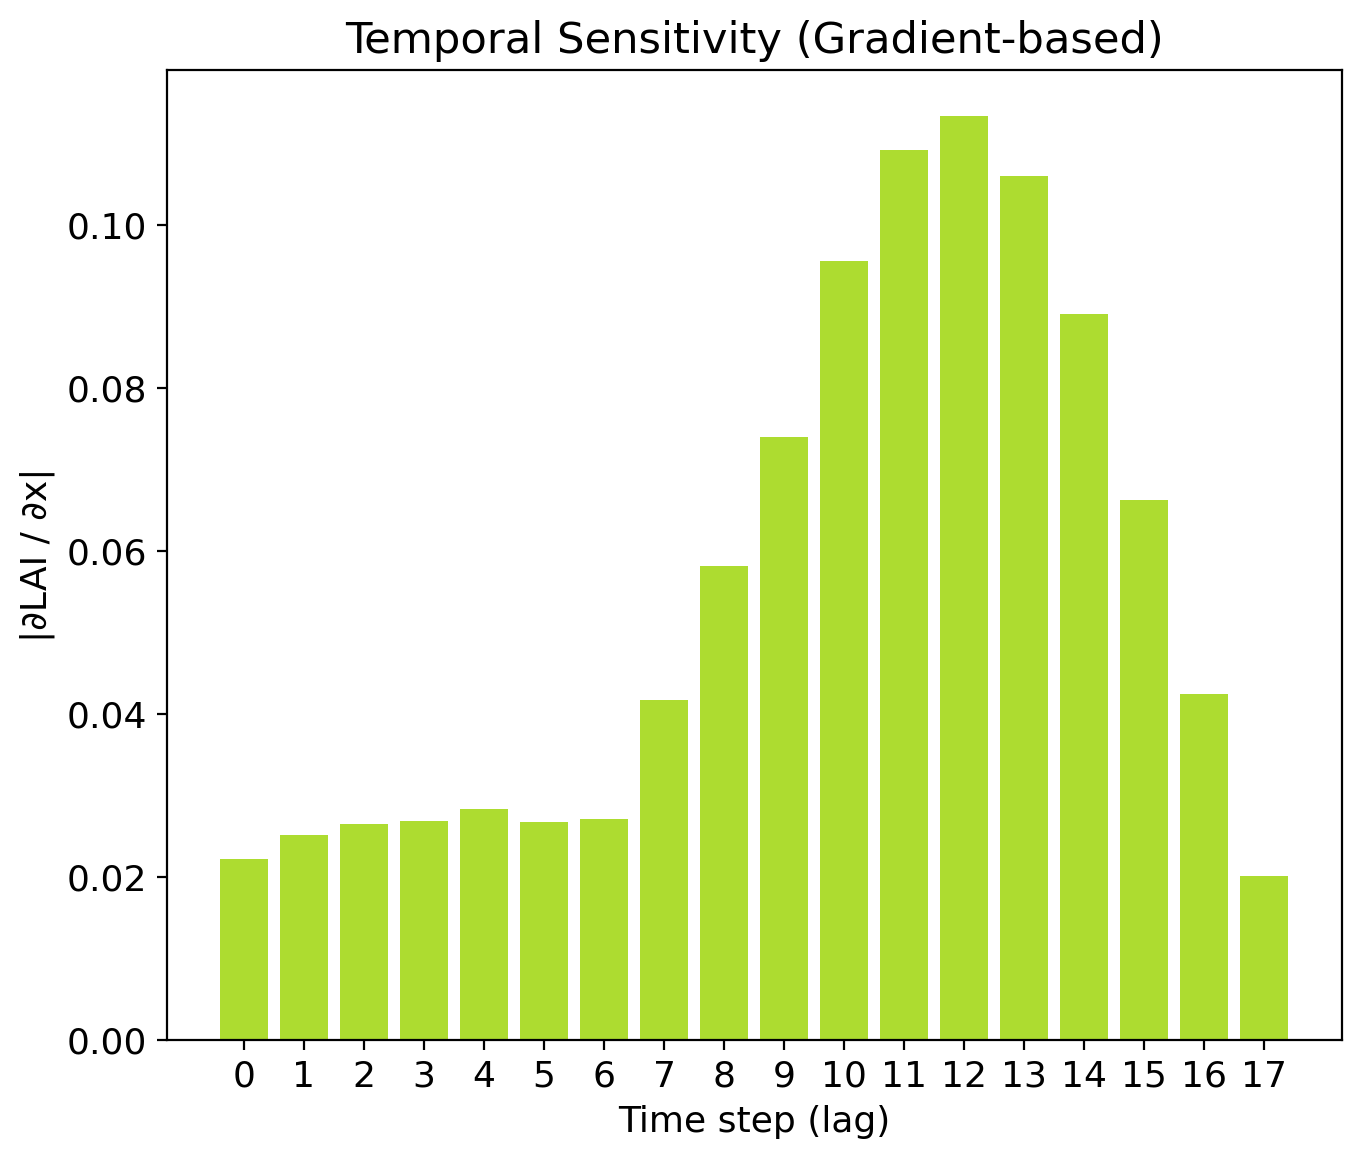

In [29]:
# CHANGED

lags = np.arange(lookback)

model_eval.eval()

X_batch, _ = next(iter(sens_loader))
X_batch = X_batch.to(device)
X_batch.requires_grad_(True)

y_pred, _, _ = model_eval(X_batch)
y_pred.mean().backward()

# Feature sensitivity (global)
feature_sensitivity = X_batch.grad.abs().mean(dim=(0,1)).cpu().numpy()

print(feature_sensitivity)

time_sensitivity = X_batch.grad.abs().mean(dim=(0,2)).cpu().numpy()

print(time_sensitivity)

feature_sensitivity = feature_sensitivity / feature_sensitivity.sum()
time_sensitivity = time_sensitivity / time_sensitivity.sum()

lookback = len(time_sensitivity)
lags = np.arange(lookback)





import matplotlib.pyplot as plt
import numpy as np

feature_names = [
    "max temperature",
    "min temperature",
    "precipitation",
    "PDSI",
    "water deficit",
    "VPD",
    "soil moisture"
]

plt.figure(figsize=(7, 6))
plt.bar(feature_names, feature_sensitivity, color="#3e4989")
plt.ylabel("|∂LAI / ∂x|")
plt.title("Feature Sensitivity (Gradient-based)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 6))
plt.bar(lags, time_sensitivity, color="#addc30")
plt.xlabel("Time step (lag)")
plt.ylabel("|∂LAI / ∂x|")
plt.xticks(lags)
plt.title("Temporal Sensitivity (Gradient-based)")
plt.tight_layout()
plt.show()

# plt.figure(figsize=(6,4))
# plt.bar(np.arange(lookback)[::-1], time_sensitivity)
# plt.xlabel("Months before prediction")
# plt.ylabel("|∂LAI / ∂x|")
# plt.title("Temporal Sensitivity (Gradient-based)")
# plt.tight_layout()
# plt.show()

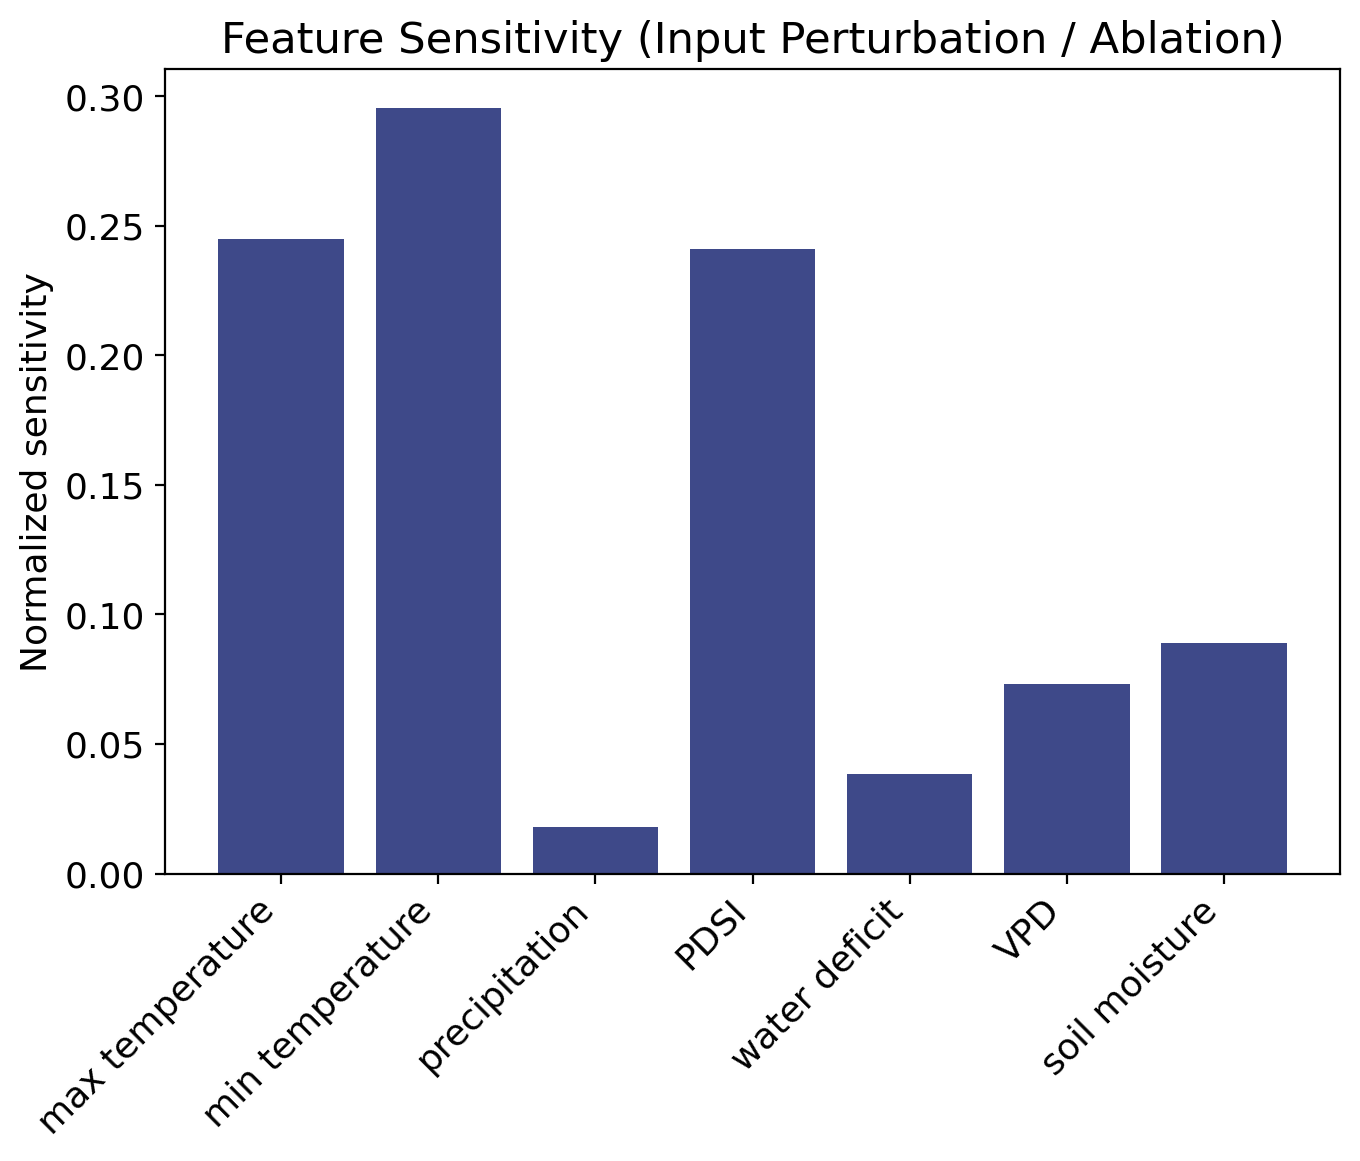

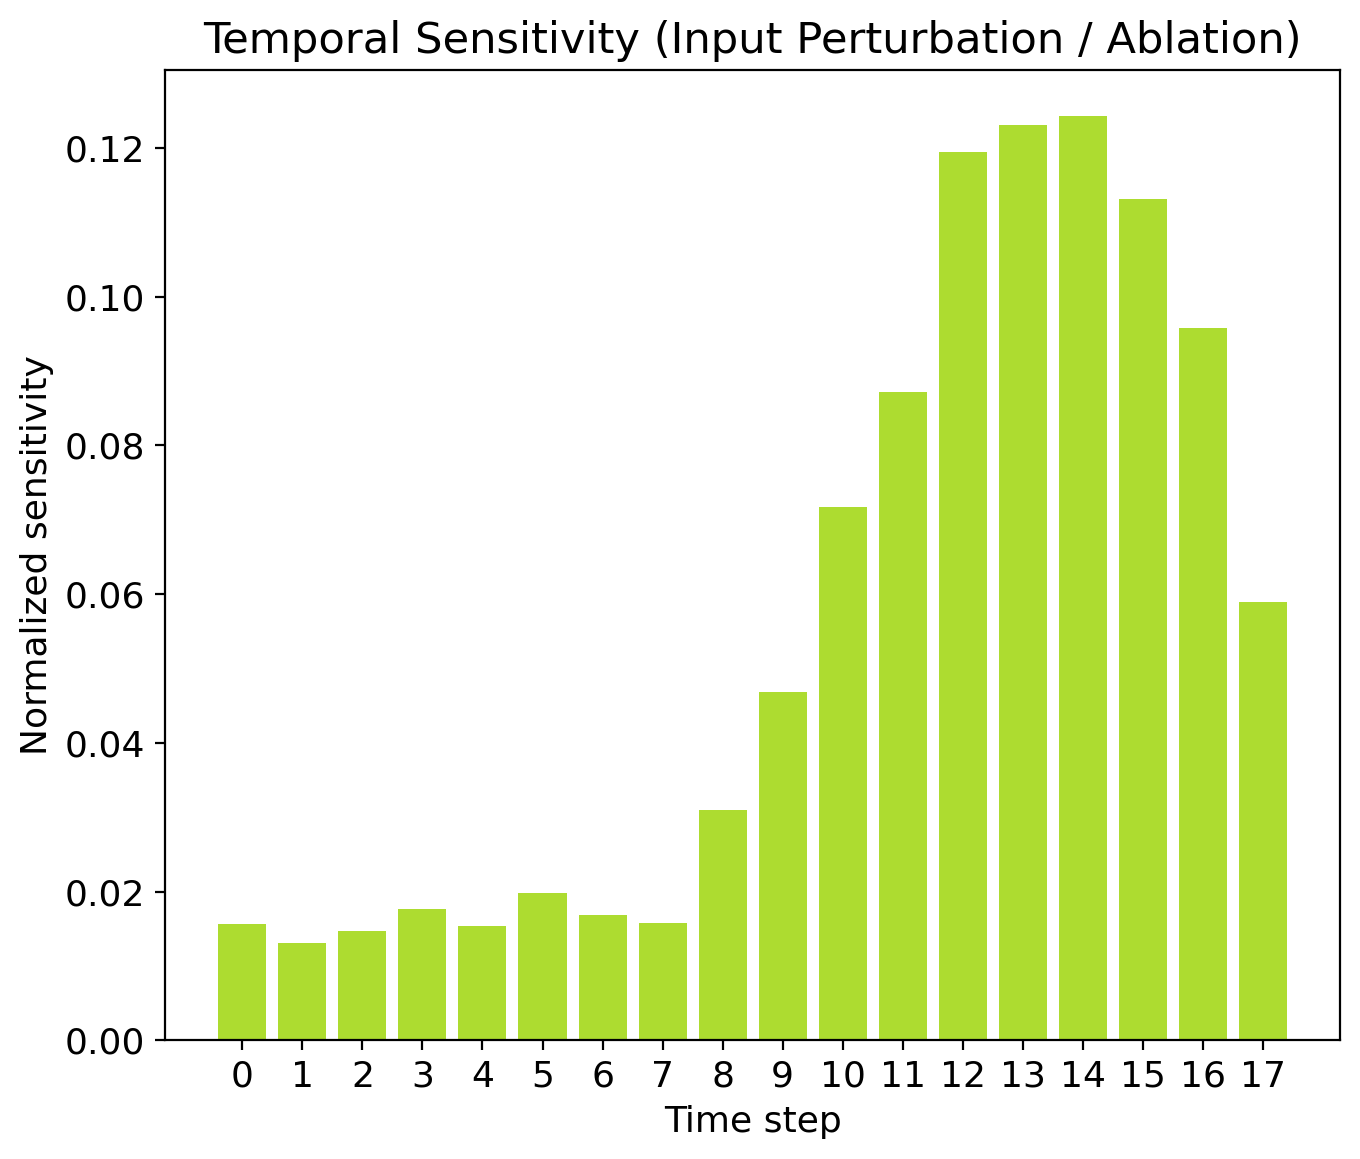

In [30]:
import torch
import numpy as np

model_eval.eval()

lags = np.arange(lookback)

# Get a batch (or loop over the entire test set for global sensitivity)
X_batch, _ = next(iter(sens_loader))
X_batch = X_batch.to(device)

# Original predictions
with torch.no_grad():
    y_pred_orig, _, _ = model_eval(X_batch)

# Compute feature-wise sensitivity
num_features = X_batch.shape[2]
feature_sens = []

for f in range(num_features):
    # Create a perturbed copy of the input
    X_perturbed = X_batch.clone()
    
    # Replace the f-th feature with its mean across the batch and timesteps
    mean_val = X_perturbed[:,:,f].mean()
    X_perturbed[:,:,f] = mean_val
    
    # Get predictions
    with torch.no_grad():
        y_pred_perturbed, _, _ = model_eval(X_perturbed)
    
    # Sensitivity = mean absolute change
    delta = torch.abs(y_pred_orig - y_pred_perturbed).mean().item()
    feature_sens.append(delta)

feature_sens = np.array(feature_sens)

# Optional: normalize to sum=1
feature_sens_norm = feature_sens / feature_sens.sum()

# print("Feature sensitivities:", feature_sens)

import matplotlib.pyplot as plt

feature_names = [
    "max temperature",
    "min temperature",
    "precipitation",
    "PDSI",
    "water deficit",
    "VPD",
    "soil moisture"
]

plt.figure(figsize=(7, 6))
plt.bar(feature_names, feature_sens_norm, color="#3e4989")
plt.ylabel("Normalized sensitivity")
plt.title("Feature Sensitivity (Input Perturbation / Ablation)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Temporal ablation (timestep-level sensitivity)
time_sens = []
seq_len = X_batch.shape[1]
for t in range(seq_len):
    X_perturbed = X_batch.clone()
    X_perturbed[:,t,:] = X_perturbed[:,t,:].mean(dim=1, keepdim=True)
    with torch.no_grad():
        y_pred_perturbed, _, _ = model_eval(X_perturbed)
    delta = torch.abs(y_pred_orig - y_pred_perturbed).mean().item()
    time_sens.append(delta)

time_sens = np.array(time_sens) / np.sum(time_sens)

# print(time_sens)

import matplotlib.pyplot as plt
import numpy as np

lookback = len(time_sens)

# Option 1: index = timestep in sequence (0 = oldest, last = most recent)
plt.figure(figsize=(7, 6))
plt.bar(np.arange(lookback), time_sens, color="#addc30")
plt.xlabel("Time step")
plt.xticks(lags)
plt.ylabel("Normalized sensitivity")
plt.title("Temporal Sensitivity (Input Perturbation / Ablation)")
plt.tight_layout()
plt.show()

# # Option 2: months before prediction (reversed so left = most recent)
# plt.figure(figsize=(6,4))
# plt.bar(np.arange(lookback), time_sens[::-1], color="#addc30")
# plt.xlabel("Months before prediction")
# plt.ylabel("Normalized sensitivity")
# plt.title("Temporal Sensitivity (Input Perturbation / Ablation)")
# plt.tight_layout()
# plt.show()


## Variable Importances 

In [31]:
# CHANGED

model_eval.eval()

all_feature_attn = []
all_time_attn = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)

        _, feature_attn, time_attn = model_eval(batch_X)

        all_feature_attn.append(feature_attn.cpu())
        all_time_attn.append(time_attn.cpu())

# Stack and average
all_feature_attn = torch.cat(all_feature_attn, dim=0)
all_time_attn = torch.cat(all_time_attn, dim=0)

var_importance = all_feature_attn.mean(dim=0)
time_importance = all_time_attn.squeeze(-1).mean(dim=0)


/tmp/ipykernel_750/3069770632.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(


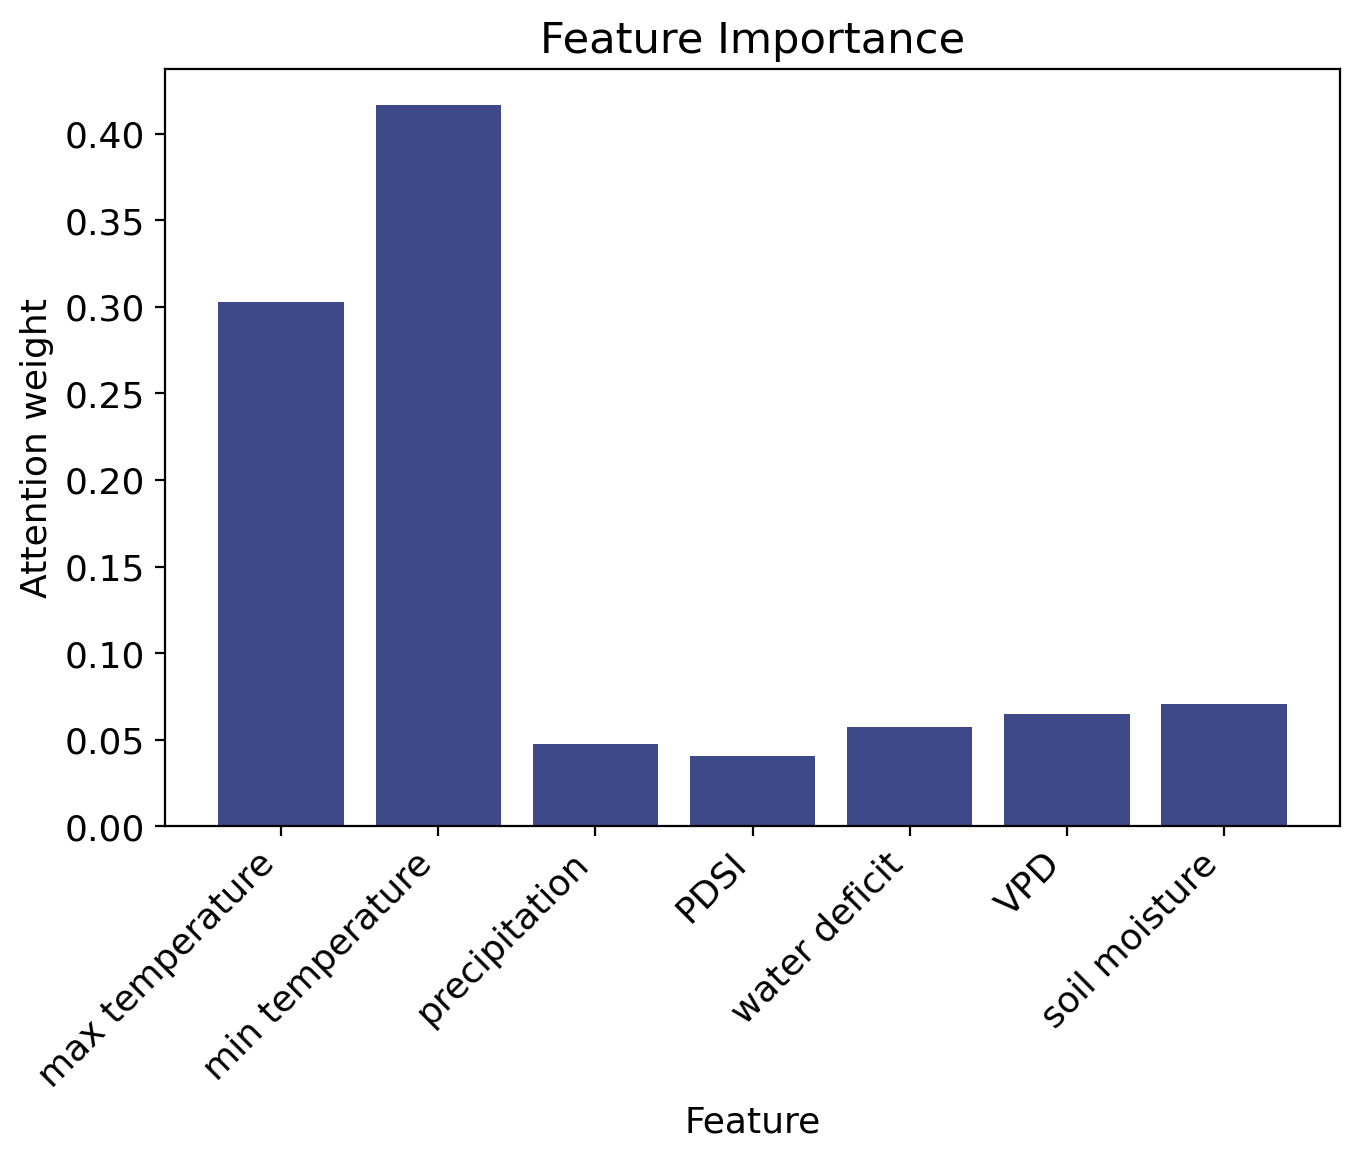

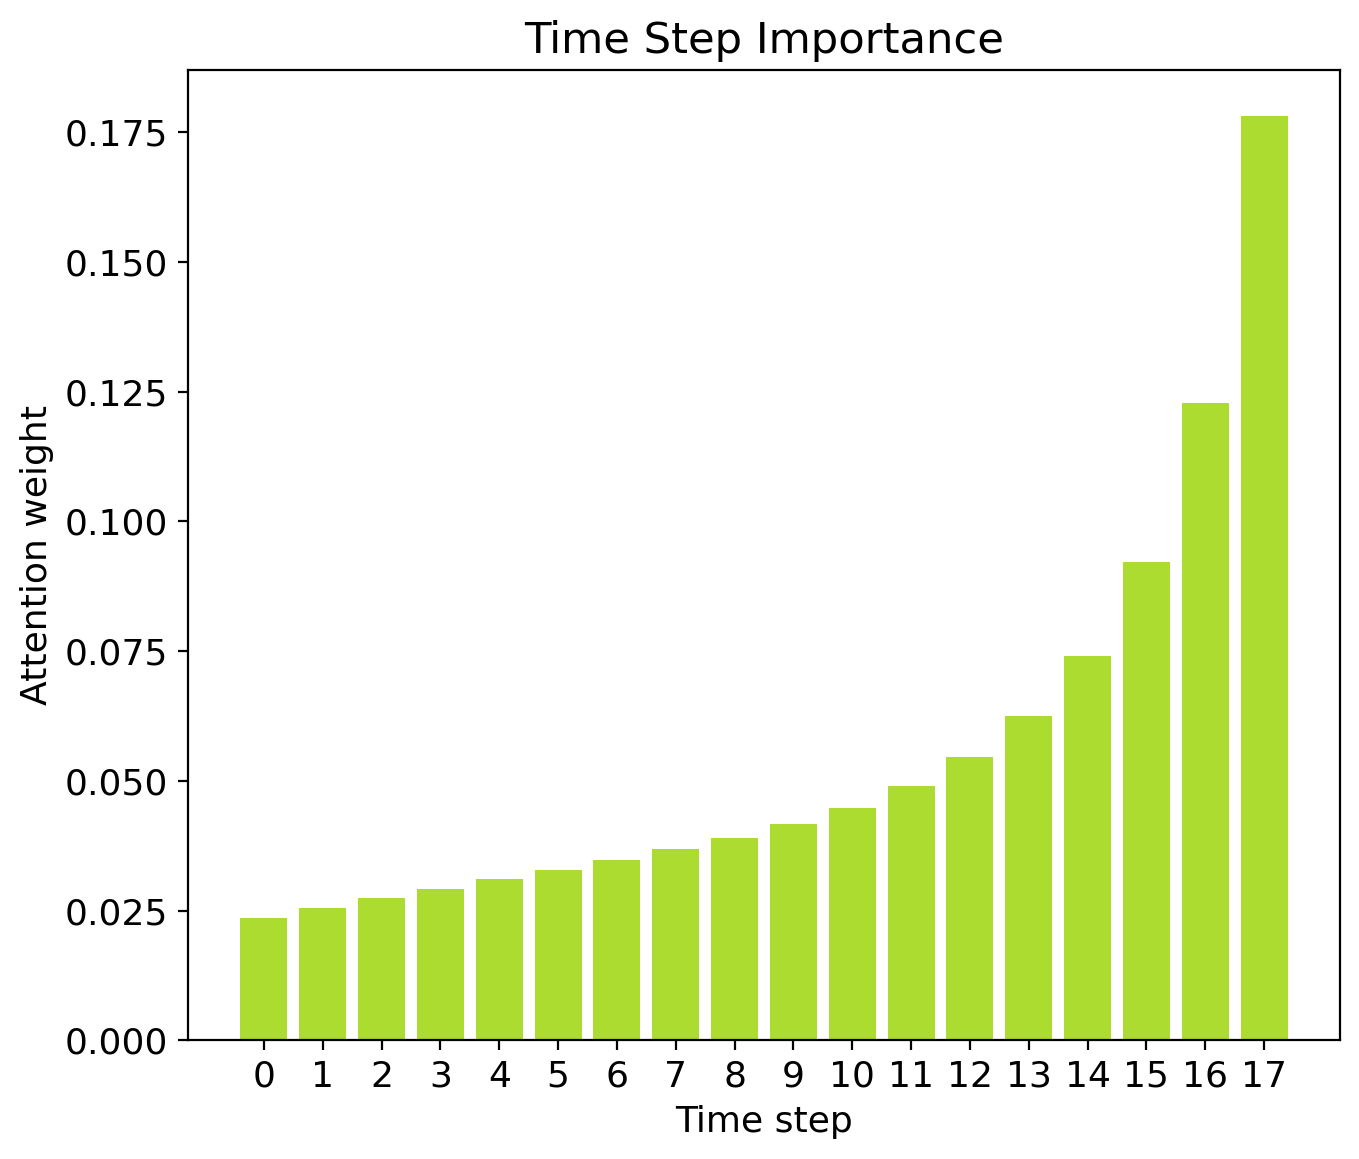

In [32]:
# CHANGED

var_imp_np = var_importance.numpy()
time_imp_np = time_importance.numpy()

feature_names = ["max temperature",
                 "min temperature",
                 "precipitation",
                 "PDSI",
                 "water deficit",
                 "VPD",
                 "soil moisture"]
plt.figure(figsize=(7, 6))
plt.bar(feature_cols, var_imp_np, color="#3e4989")
plt.gca().set_xticklabels(
    feature_names,
    rotation=45,
    ha="right"
)
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Attention weight")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 6))
plt.bar(
    range(len(time_imp_np)),
    time_imp_np,
    color="#addc30"
)
plt.xticks(
    ticks=range(len(time_imp_np)),   # tick at every timestep
    labels=range(len(time_imp_np))   # label each timestep
)
plt.title("Time Step Importance")
plt.xlabel("Time step")
plt.ylabel("Attention weight")
plt.tight_layout()
plt.show()

In [33]:
# overall RMSE and MAE
overall_rmse = np.sqrt(np.mean((preds - targets)**2))
print("Overall RMSE:", overall_rmse)

overall_mae = np.mean(np.abs(preds - targets))
print("Overall MAE:", overall_mae)

# Overall R²
ss_res = np.sum((targets - preds)**2)
ss_tot = np.sum((targets - np.mean(targets))**2)
overall_r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan
print("Overall R²:", overall_r2)




Overall RMSE: 0.29225114
Overall MAE: 0.20329168
Overall R²: -0.1196028


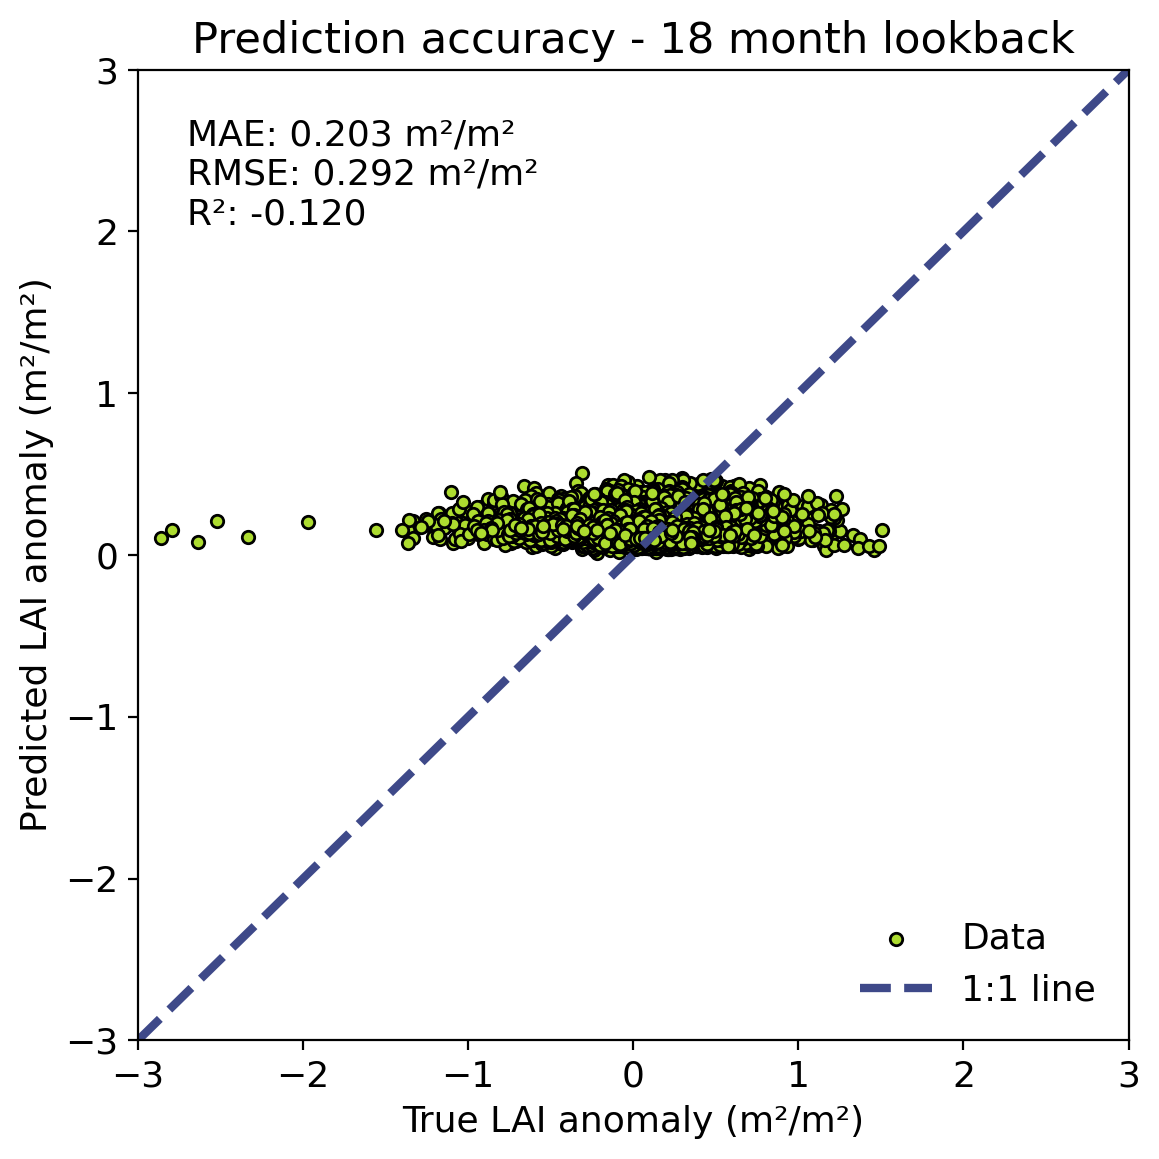

np.float32(-0.1196028)

In [34]:
# # Scatter plot: True vs Pred
# plt.figure(figsize=(6,6))
# plt.scatter(targets, preds, alpha=0.5, color="tab:blue", edgecolor="k")

# # 1:1 reference line
# min_val = min(targets.min(), preds.min())
# max_val = max(targets.max(), preds.max())
# plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="1:1 line")

# plt.xlabel("True")
# plt.ylabel("Predicted")
# plt.title(f"LAI prediction accuracy - {lookback} month loockback")

# # Annotate metrics
# plt.text(0.05, 0.95,
#          f"RMSE: {overall_rmse:.3f}\nMAE: {overall_mae:.3f}\nR²: {overall_r2:.3f}",
#          transform=plt.gca().transAxes,
#          verticalalignment='top',
#          bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# plt.legend()
# plt.tight_layout()
# plt.show()

def plot_true_vs_pred(
    targets,
    preds,
    overall_rmse=None,
    overall_mae=None,
    point_color="tab:blue",
    edge_color="k",
    line_color="r",
    alpha=1,
    xlim=None,
    ylim=None,
    figsize=(6, 6),
    point_size=15,
    line_width=2.5
):
    # ---- R² ----
    ss_res = np.sum((targets - preds) ** 2)
    ss_tot = np.sum((targets - np.mean(targets)) ** 2)
    overall_r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

    # ---- Plot ----
    plt.figure(figsize=figsize)
    plt.scatter(
        targets,
        preds,
        s=point_size,
        alpha=alpha,
        edgecolor=edge_color,
        color=point_color,
        label="Data"
    )

    # ---- 1:1 line ----
    if xlim is None:
        min_val = min(targets.min(), preds.min())
        max_val = max(targets.max(), preds.max())
    else:
        min_val, max_val = xlim

    plt.plot(
        [min_val, max_val],
        [min_val, max_val],
        linestyle="--",
        linewidth=line_width,
        color=line_color,
        label="1:1 line"
    )

    # ---- Axis limits ----
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    # ---- Labels ----
    plt.xlabel("True LAI anomaly (m²/m²)")
    plt.ylabel("Predicted LAI anomaly (m²/m²)")
    plt.title(f"Prediction accuracy - {lookback} month lookback")

    # ---- Metrics text (NO BOX) ----
    metrics = f"R²: {overall_r2:.3f}"
    if overall_rmse is not None:
        metrics = f"RMSE: {overall_rmse:.3f} m²/m²\n" + metrics
    if overall_mae is not None:
       metrics = f"MAE: {overall_mae:.3f} m²/m²\n" + metrics

    plt.text(
        0.05, 0.95,
        metrics,
        transform=plt.gca().transAxes,
        va="top"
    )

    plt.legend()
    plt.tight_layout()
    plt.show()

    return overall_r2

plot_true_vs_pred(
    targets,
    preds,
    overall_rmse=overall_rmse,
    overall_mae=overall_mae,
    point_color="#addc30",
    line_color="#3e4989",
    xlim=(-3, 3),
    ylim=(-3, 3),
    alpha=1,
    point_size=20,
    line_width=3
)

In [35]:
# save the rmse calculations to a raster
# def rmse_to_raster(rmse_df):
#     lats = np.sort(rmse_df["lat"].unique())
#     lons = np.sort(rmse_df["lon"].unique())

#     # Initialize raster
#     raster = np.full((len(lats), len(lons)), np.nan, dtype=float)

#     # Fill raster per coordinate
#     for _, row in rmse_df.iterrows():
#         lat_idx = np.where(lats == row["lat"])[0][0]
#         lon_idx = np.where(lons == row["lon"])[0][0]
#         raster[lat_idx, lon_idx] = row["rmse"]

#     return raster, lats, lons

def metric_to_raster(df, metric):
    lats = np.sort(df["lat"].unique())
    lons = np.sort(df["lon"].unique())

    raster = np.full((len(lats), len(lons)), np.nan, dtype=float)

    for _, row in df.iterrows():
        lat_idx = np.where(lats == row["lat"])[0][0]
        lon_idx = np.where(lons == row["lon"])[0][0]
        raster[lat_idx, lon_idx] = row[metric]

    return raster, lats, lons


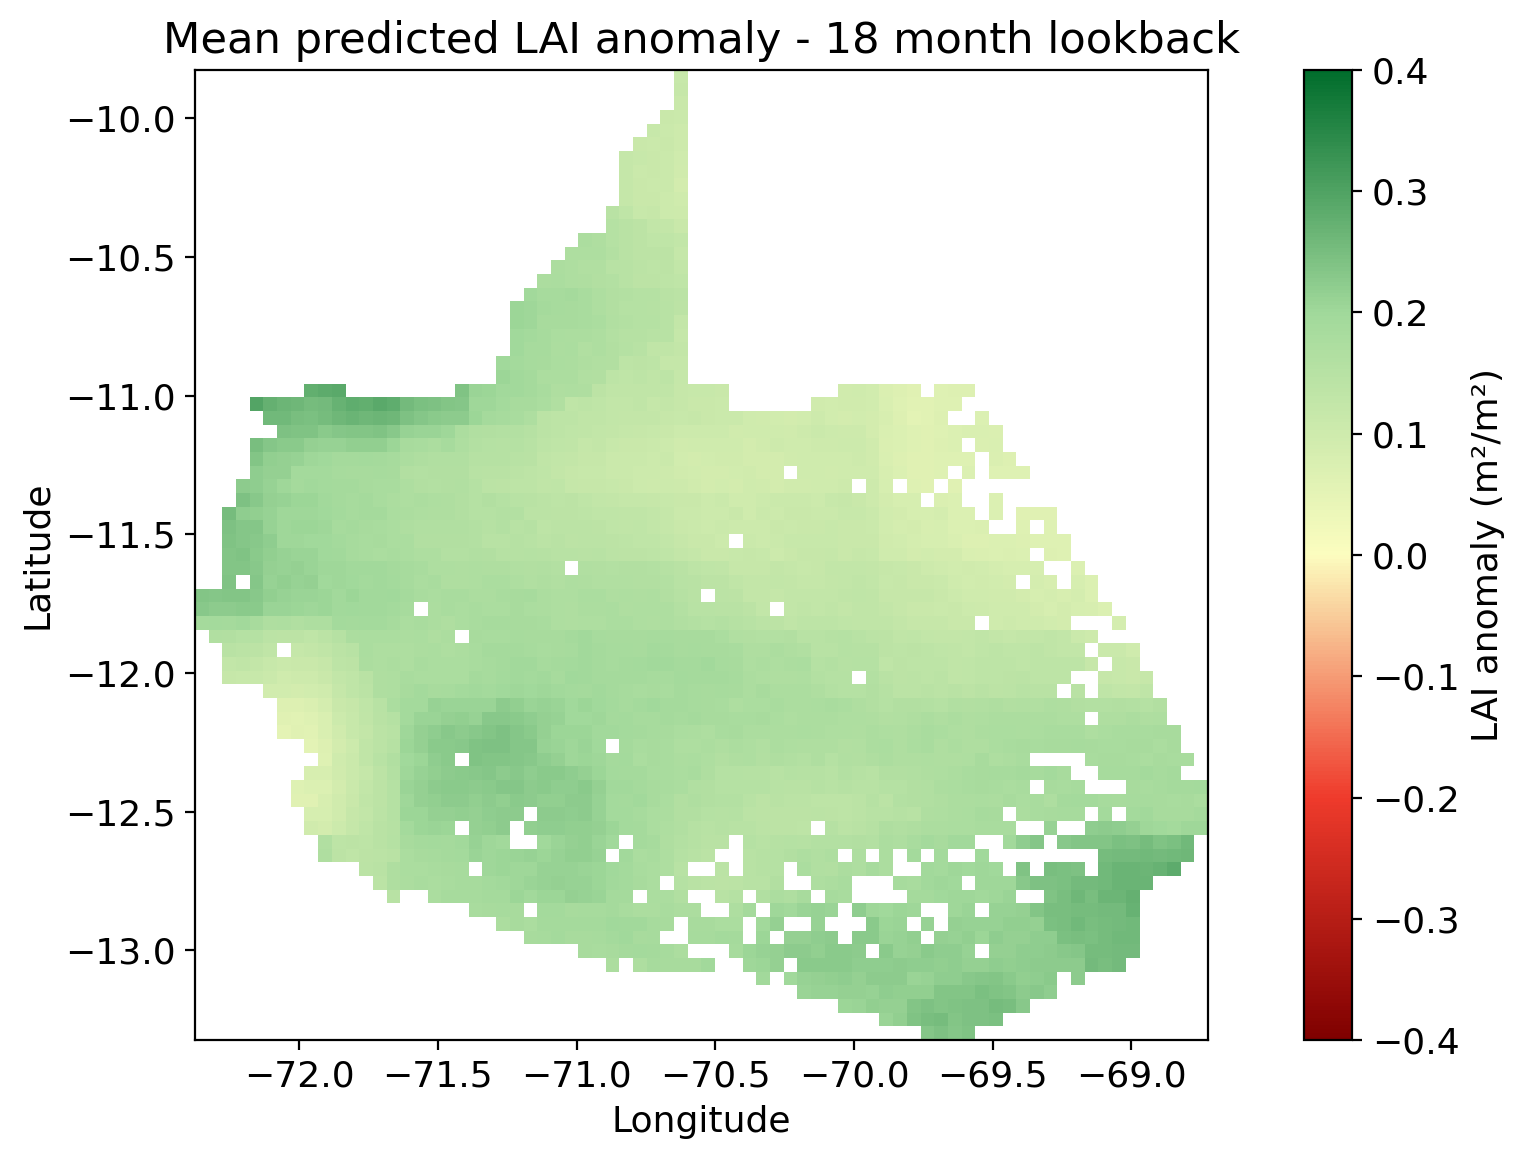

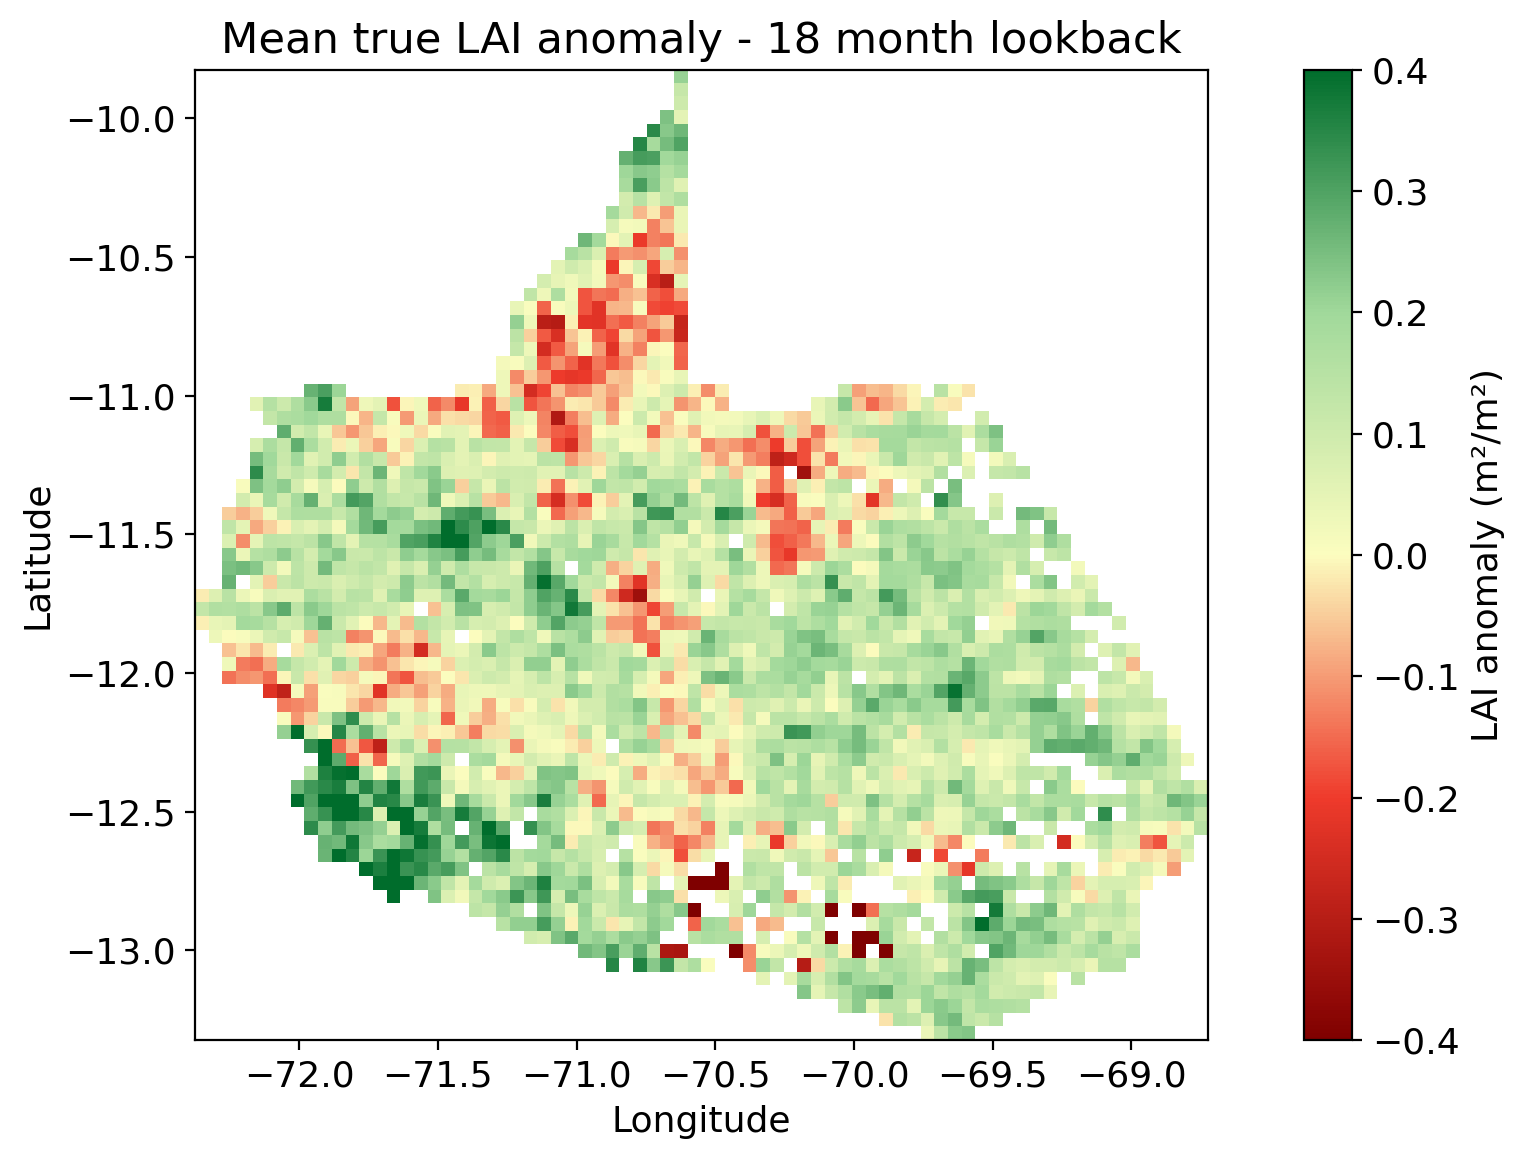

In [36]:
predsTargs = pd.DataFrame({
        "lat": coords[:, 0],
        "lon": coords[:, 1],
        "pred": preds,
        "true": targets
    })

# print(predsTargs)

predsTargs_mean = (
    predsTargs
    .groupby(["lat", "lon"], as_index=False)
    .mean(numeric_only=True)
)

# print(predsTargs_mean.head())

preds_raster, lats, lons = metric_to_raster(predsTargs_mean, "pred")
preds_raster = np.flipud(preds_raster)
targs_raster, lats, lons = metric_to_raster(predsTargs_mean, "true")
targs_raster = np.flipud(targs_raster)

# print(preds_raster)

# print(predsTargs)

import matplotlib.pyplot as plt
import matplotlib.colors as colors

# ---- MANUAL COLOR SCALE ----
vmin = -0.4   # <-- change freely
vmax =  0.4   # <-- change freely

# ---- Custom diverging colormap ----
custom_colors = [
    "#7f0000",  # dark red
    "#ef3b2c",  # light red
    "#fcfdbf",  # tan
    "#a1d99b",  # light green
    "#006d2c"   # dark green
]

cmap = colors.LinearSegmentedColormap.from_list(
    "red_tan_green",
    custom_colors,
    N=256
)

norm = colors.Normalize(vmin=vmin, vmax=vmax)

plt.figure(figsize=(10, 6))
plt.imshow(
    preds_raster,
    cmap=cmap,
    norm=norm,
    origin="upper",
    extent=[min(lons), max(lons), min(lats), max(lats)]
)
plt.colorbar(label="LAI anomaly (m²/m²)")
plt.title(f"Mean predicted LAI anomaly - {lookback} month lookback")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(
    targs_raster,
    cmap=cmap,
    norm=norm,
    origin="upper",
    extent=[min(lons), max(lons), min(lats), max(lats)]
)
plt.colorbar(label="LAI anomaly (m²/m²)")
plt.title(f"Mean true LAI anomaly - {lookback} month lookback")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


In [37]:
# compute the rmse per pixel and return a df of values INDEXED exactly as the input data
# def compute_rmse_per_pixel(coords, preds, targets):
#     df = pd.DataFrame({
#         "lat": coords[:, 0],
#         "lon": coords[:, 1],
#         "pred": preds,
#         "true": targets
#     })

#     def rmse(x, y):
#         return np.sqrt(np.mean((x - y)**2))

#     rmse_df = df.groupby(["lat", "lon"]).apply(
#         lambda g: rmse(g["pred"], g["true"])
#     ).reset_index(name="rmse")

#     return rmse_df

def compute_error_per_pixel(coords, preds, targets):
    df = pd.DataFrame({
        "lat": coords[:, 0],
        "lon": coords[:, 1],
        "pred": preds,
        "true": targets
    })

    def rmse(x, y):
        return np.sqrt(np.mean((x - y)**2))

    def mae(x, y):
        return np.mean(np.abs(x - y))

    error_df = df.groupby(["lat", "lon"]).apply(
        lambda g: pd.Series({
            "rmse": rmse(g["pred"], g["true"]),
            "mae": mae(g["pred"], g["true"])
        })
    ).reset_index()

    return error_df

In [38]:
# take a look at this!
# rmse_df = compute_rmse_per_pixel(coords, preds, targets)
# print(rmse_df.head())

error_df = compute_error_per_pixel(coords, preds, targets)
print(error_df.head())

         lat        lon      rmse       mae
0 -13.325002 -69.724998  0.256893  0.200974
1 -13.325002 -69.674995  0.190480  0.180345
2 -13.325002 -69.625000  0.167285  0.162410
3 -13.325002 -69.574997  0.168272  0.160360
4 -13.275002 -69.875000  0.388994  0.295840


/tmp/ipykernel_750/813597340.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  error_df = df.groupby(["lat", "lon"]).apply(


In [39]:
# run raster saving function from above
# rmse_raster, lats, lons = rmse_to_raster(rmse_df)
# rmse_raster = np.flipud(rmse_raster)
# lats = lats[::-1]
# print(rmse_raster.shape)

rmse_raster, lats, lons = metric_to_raster(error_df, "rmse")
rmse_raster = np.flipud(rmse_raster)

mae_raster, mae_lats, mae_lons = metric_to_raster(error_df, "mae")
mae_raster = np.flipud(mae_raster)

rmse_lats = lats[::-1]
print(rmse_raster.shape)
print(mae_raster.shape)
print(rmse_raster)
# print(mae_raster)

(71, 74)
(71, 74)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [40]:
# save your rmse raster to a geotiff
import rasterio
from rasterio.transform import from_origin

def save_rmse_geotiff(filename, raster, lats, lons):
    # Compute resolution
    lat_res = abs(lats[1] - lats[0])
    lon_res = abs(lons[1] - lons[0])
    
    transform = from_origin(min(lons), max(lats), lon_res, lat_res)

    with rasterio.open(
        filename,
        "w",
        driver="GTiff",
        height=raster.shape[0],
        width=raster.shape[1],
        count=1,
        dtype=raster.dtype,
        crs="EPSG:4326",
        transform=transform,
    ) as dst:
        dst.write(raster, 1)

In [41]:
# run and save! name your save with the length of the looback window
# save_rmse_geotiff(f"/home/jovyan/MLEAEEE4000-DroughtAmazon2/figures/RMSE_maps/v{model_version}/attn_lkb{lookback}.tif", rmse_raster, lats, lons)

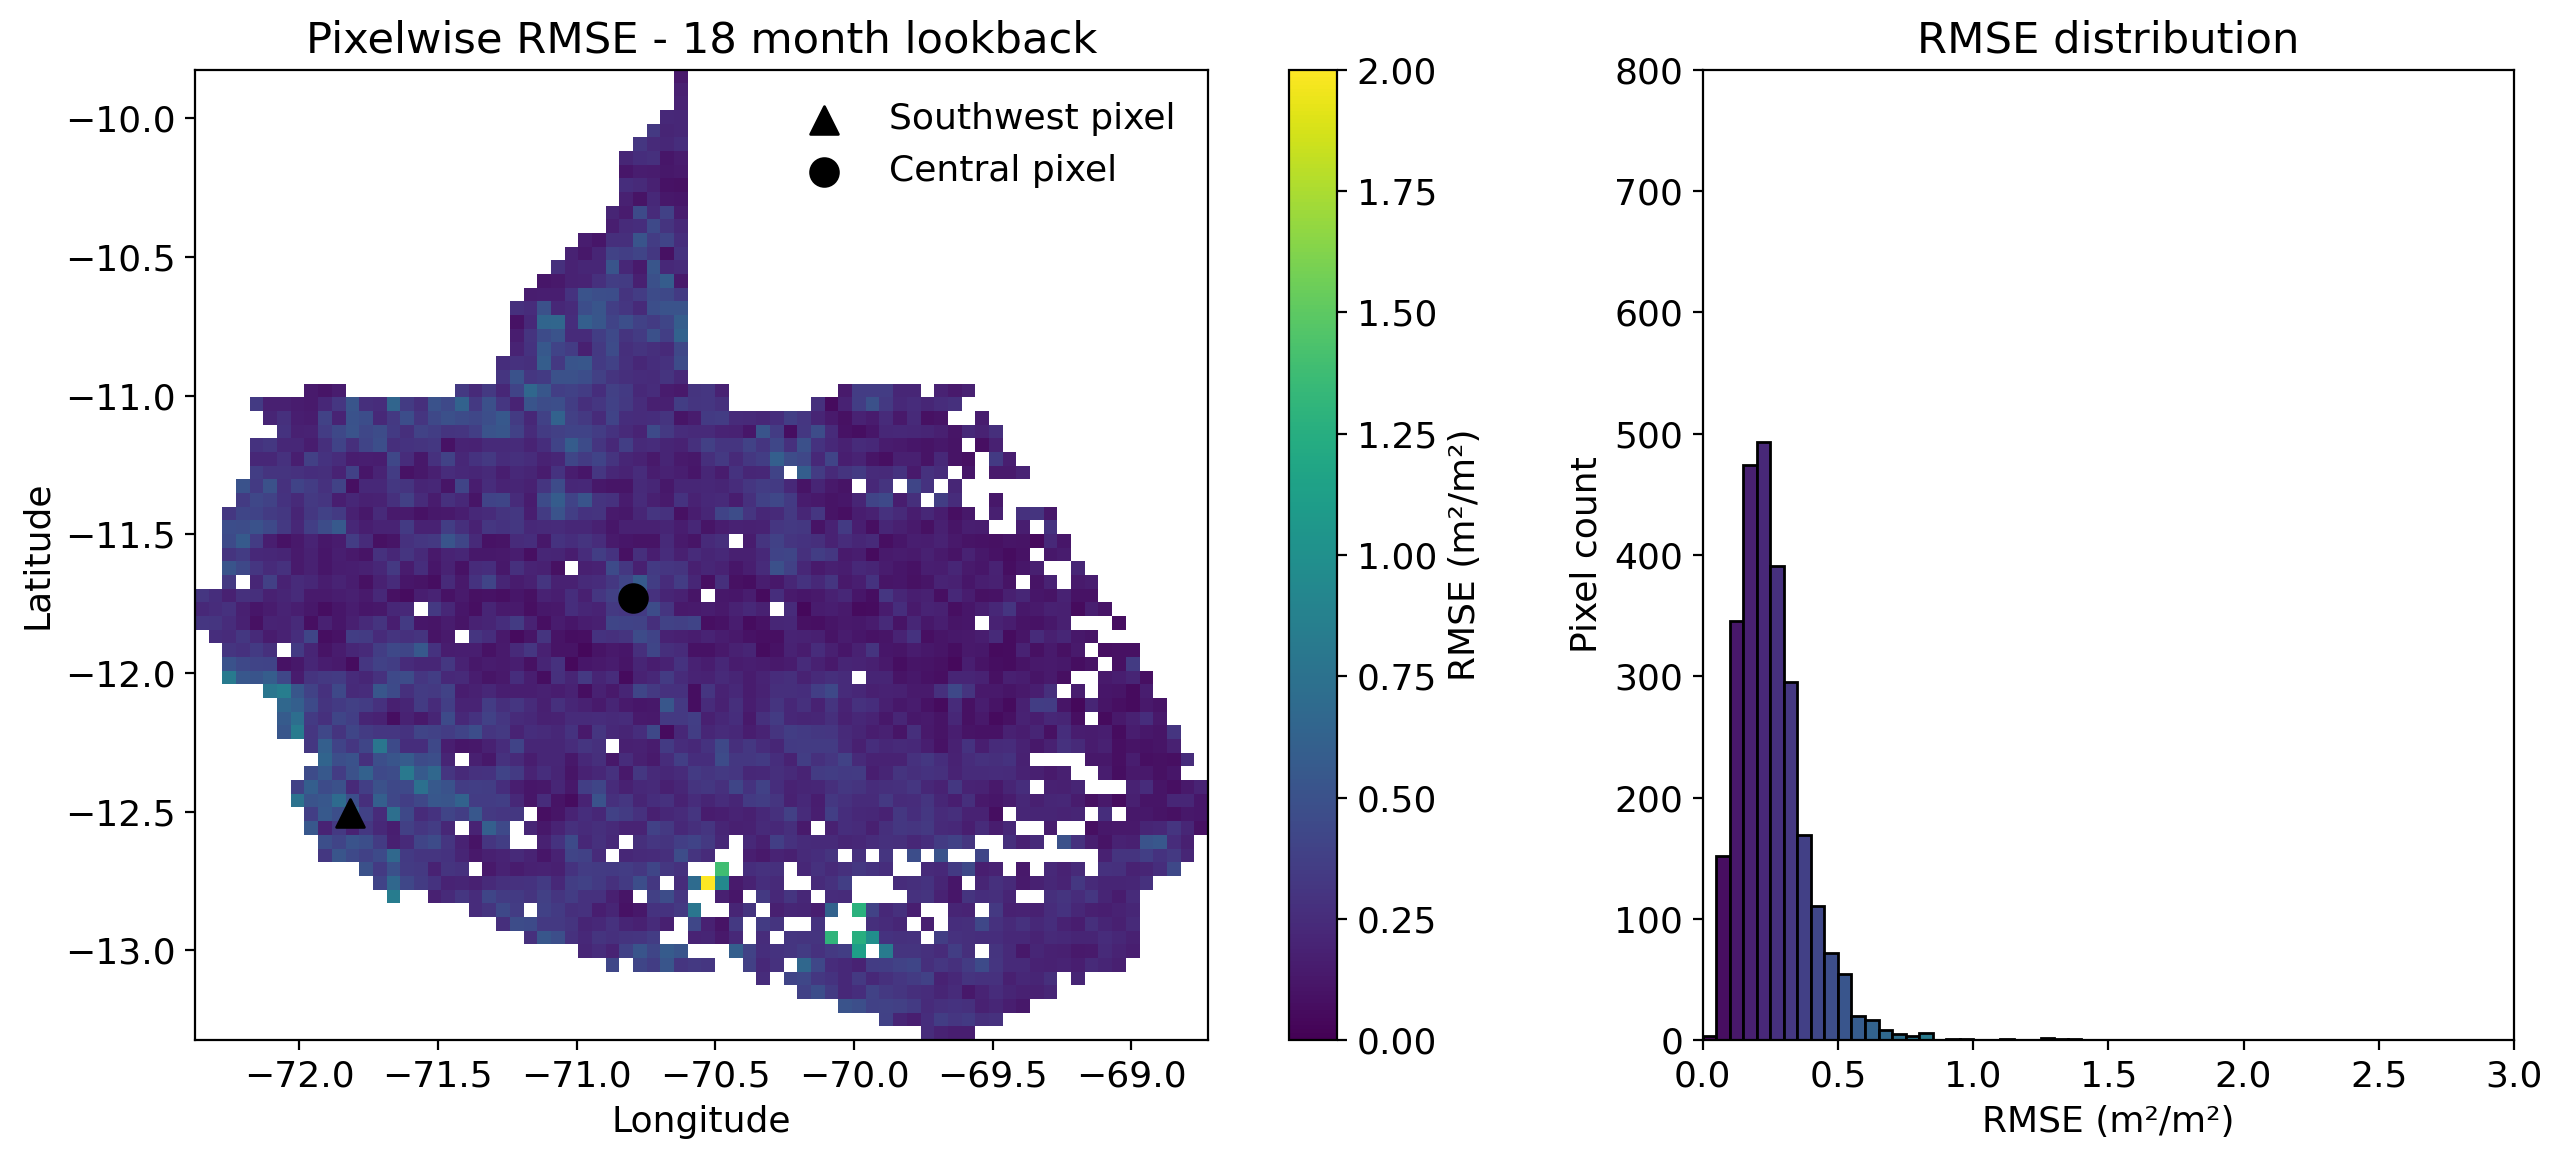

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# ======================================================
# User-defined reference points
# ======================================================
sw_lat, sw_lon = -12.504240199016463, -71.818702040585   # southwest
ct_lat, ct_lon = -11.730855612666398, -70.79697352496   # central

# ======================================================
# Helper: extract raster value at lat/lon (nearest valid)
# ======================================================
def extract_nearest_valid(raster, lats, lons, lat, lon, max_search=5):
    lat_idx = np.argmin(np.abs(lats - lat))
    lon_idx = np.argmin(np.abs(lons - lon))

    for w in range(max_search):
        lat_slice = slice(max(lat_idx-w,0), min(lat_idx+w+1,raster.shape[0]))
        lon_slice = slice(max(lon_idx-w,0), min(lon_idx+w+1,raster.shape[1]))
        sub_raster = raster[lat_slice, lon_slice]
        if np.any(np.isfinite(sub_raster)):
            return np.nanmean(sub_raster)
    return np.nan  # no valid neighbors

# ======================================================
# Extract RMSE values at reference points
# ======================================================
rmse_sw = extract_nearest_valid(rmse_raster, lats, lons, sw_lat, sw_lon)
rmse_ct = extract_nearest_valid(rmse_raster, lats, lons, ct_lat, ct_lon)

# print(f"SW RMSE: {rmse_sw:.3f} m²/m²")
# print(f"CT RMSE: {rmse_ct:.3f} m²/m²")

# ---- Shared color scale ----
vmin = 0.0
vmax = 2.0
cmap = plt.cm.viridis
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# ---- Histogram axis controls ----
hist_xlim = (0, 3)
hist_ylim = (0, 800)

# ---- Figure ----
fig, (ax_map, ax_hist) = plt.subplots(
    1, 2, figsize=(14, 6),
    gridspec_kw={"width_ratios": [2, 1]}
)

# ---- RMSE map ----
im = ax_map.imshow(
    rmse_raster,
    cmap=cmap,
    norm=norm,
    origin="upper",
    extent=[min(lons), max(lons), min(lats), max(lats)]
)

cbar = fig.colorbar(im, ax=ax_map)
cbar.set_label("RMSE (m²/m²)")

ax_map.set_title(f"Pixelwise RMSE - {lookback} month lookback")
ax_map.set_xlabel("Longitude")
ax_map.set_ylabel("Latitude")

# ---- Add points with different markers ----
ax_map.scatter(sw_lon, sw_lat, s=100, c='black', marker='^', edgecolor='black', zorder=5, label="Southwest pixel")
ax_map.scatter(ct_lon, ct_lat, s=100, c='black', marker='o', edgecolor='black', zorder=5, label="Central pixel")

ax_map.legend(loc="upper right", frameon=False)

# ---- Histogram ----
rmse_flat = rmse_raster[np.isfinite(rmse_raster)]

n, bins, patches = ax_hist.hist(
    rmse_flat,
    bins=40,
    range=(vmin, vmax),
    edgecolor="black"
)

# Color bins with same colormap
for patch, left, right in zip(patches, bins[:-1], bins[1:]):
    bin_center = 0.5 * (left + right)
    patch.set_facecolor(cmap(norm(bin_center)))

# ---- Histogram axes ----
if hist_xlim is not None:
    ax_hist.set_xlim(hist_xlim)
if hist_ylim is not None:
    ax_hist.set_ylim(hist_ylim)

ax_hist.set_xlabel("RMSE (m²/m²)")
ax_hist.set_ylabel("Pixel count")
ax_hist.set_title("RMSE distribution")

plt.tight_layout()
plt.show()

# ---- Debug prints ----
# print("Raster lat range:", lats.min(), "to", lats.max())
# print("Raster lon range:", lons.min(), "to", lons.max())
# print("SW point:", sw_lat, sw_lon)
# print("CT point:", ct_lat, ct_lon)

lat_idx = np.argmin(np.abs(lats - sw_lat))
lon_idx = np.argmin(np.abs(lons - sw_lon))

# print("SW pixel indices:", lat_idx, lon_idx)
# print("SW raster value:", rmse_raster[lat_idx, lon_idx])


In [43]:
# # plot your rmse raster
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10,6))
# plt.imshow(mae_raster, cmap="viridis", origin="upper",
#            extent=[min(lons), max(lons), min(lats), max(lats)])
# plt.colorbar(label="MAE")
# plt.title("Pixel-wise MAE for LAI prediction, 3 month look-back window")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.show()

In [44]:
# print(dir(test_dataset))
# print(test_dataset)

# seq_len = test_dataset.X.shape[1]
# N = len(test_dataset)

# N

df = pd.DataFrame({
    "time": test_times,
    "pred": preds.squeeze(),
    "true": targets.squeeze(),
    "lat": coords[:, 0],
    "lon": coords[:, 1]
})

# print(df)

# print(times_testing)

# print(len(preds))
# print(len(targets))
# print(len(test_times))

# print(df[['lat','lon']].head())
# print(df[['lat','lon']].describe())

# print(df[['lat','lon']].drop_duplicates().shape)
# print(df[['lat','lon']].drop_duplicates().head(20))

# df.time.iloc[0], type(df.time.iloc[0])

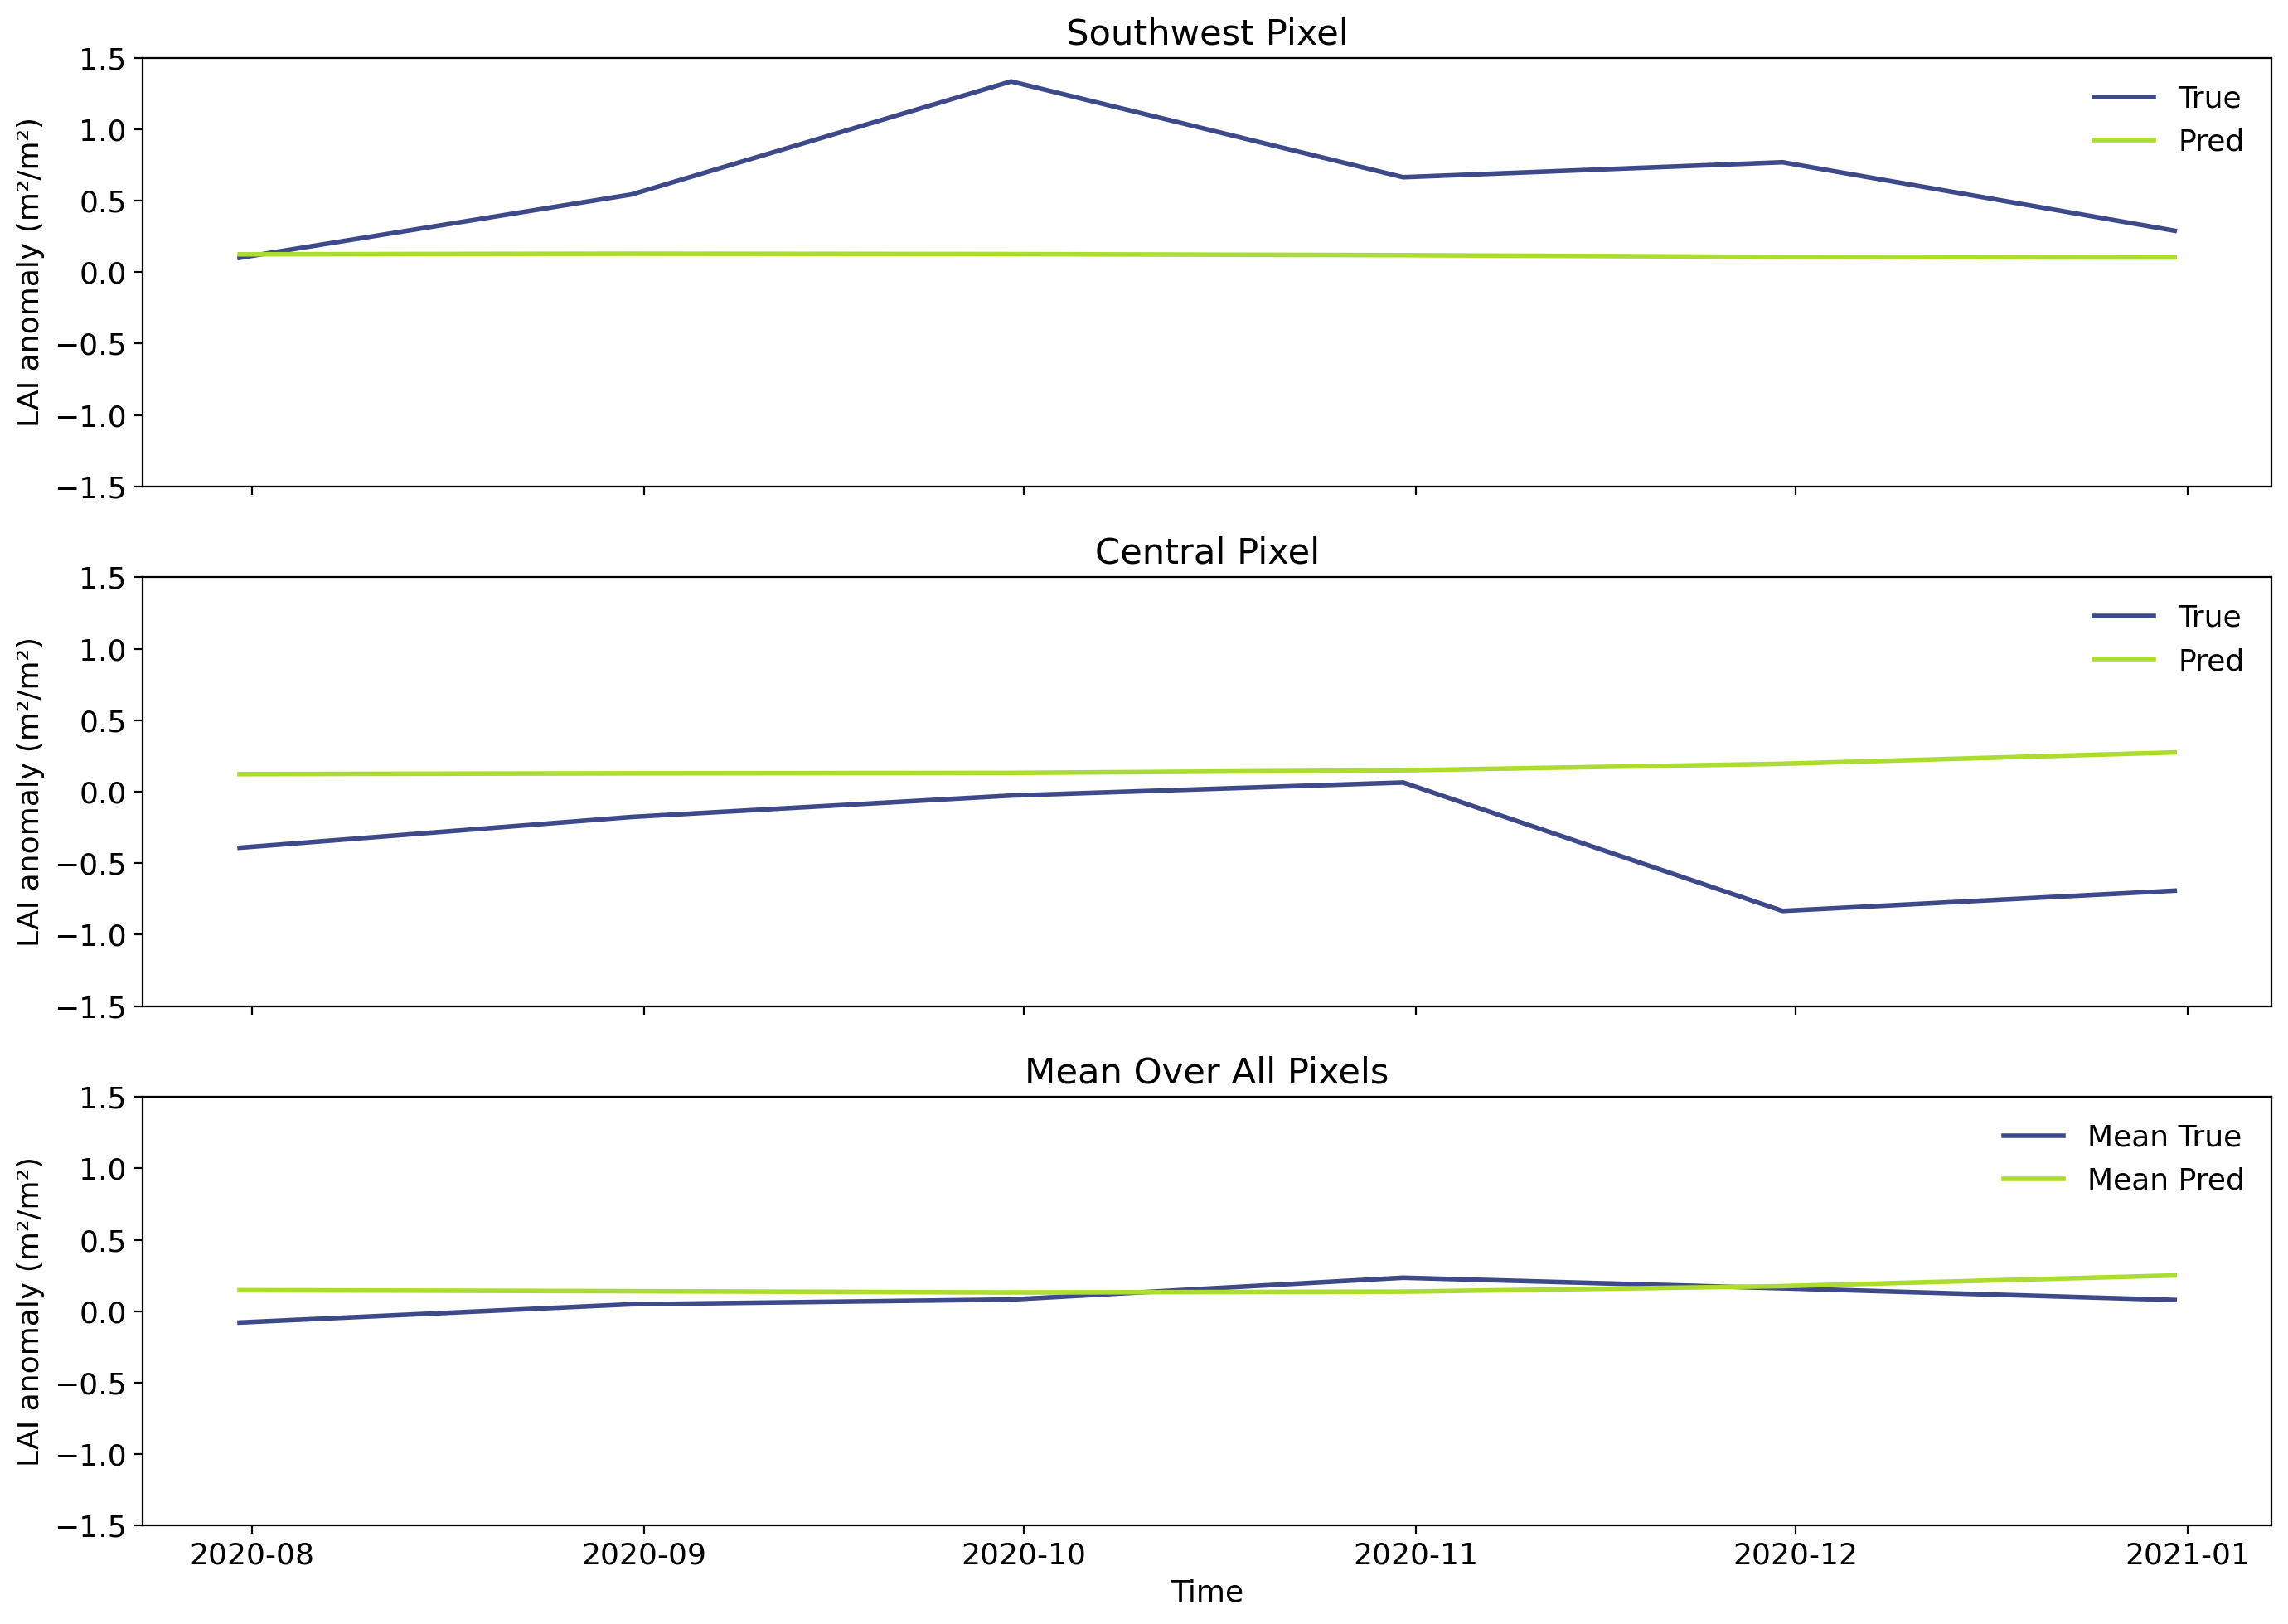

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# --- Define your two points ---
sw_lat, sw_lon = -12.504240199016463, -71.818702040585     # southwest corner  
ct_lat, ct_lon = -11.730855612666398, -70.79697352496      # central

# --- Find nearest pixel in df ---
def nearest_pixel(df, target_lat, target_lon):
    d = np.sqrt((df.lat - target_lat)**2 + (df.lon - target_lon)**2)
    idx = d.idxmin()
    return df.loc[idx, ['lat','lon']]

sw_actual = nearest_pixel(df, sw_lat, sw_lon)
ct_actual = nearest_pixel(df, ct_lat, ct_lon)

pix_sw = df[(df.lat == sw_actual.lat) & (df.lon == sw_actual.lon)]
pix_ct = df[(df.lat == ct_actual.lat) & (df.lon == ct_actual.lon)]

# --- Compute mean time series ---
mean_ts = df.groupby("time")[["pred","true"]].mean()

# --- Determine common y-axis limits ---
ymin = min(pix_sw.true.min(), pix_sw.pred.min(),
           pix_ct.true.min(), pix_ct.pred.min(),
           mean_ts.true.min(), mean_ts.pred.min())
ymax = max(pix_sw.true.max(), pix_sw.pred.max(),
           pix_ct.true.max(), pix_ct.pred.max(),
           mean_ts.true.max(), mean_ts.pred.max())
ymin = -1.5
ymax = 1.5

# --- Plot all three subplots with same size and axes ---
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True, sharey=True)

# Colors
true_color = "#3e4989"
pred_color = "#addc30"

# Southwest pixel
axes[0].plot(pix_sw.time, pix_sw.true, label="True", color=true_color, linewidth=2)
axes[0].plot(pix_sw.time, pix_sw.pred, label="Pred", color=pred_color, linewidth=2)
axes[0].set_title("Southwest Pixel")
axes[0].legend()
axes[0].set_ylabel("LAI anomaly (m²/m²)")

# Central pixel
axes[1].plot(pix_ct.time, pix_ct.true, label="True", color=true_color, linewidth=2)
axes[1].plot(pix_ct.time, pix_ct.pred, label="Pred", color=pred_color, linewidth=2)
axes[1].set_title("Central Pixel")
axes[1].legend()
axes[1].set_ylabel("LAI anomaly (m²/m²)")

# Mean over all pixels
axes[2].plot(mean_ts.index, mean_ts["true"], label="Mean True", color=true_color, linewidth=2)
axes[2].plot(mean_ts.index, mean_ts["pred"], label="Mean Pred", color=pred_color, linewidth=2)
axes[2].set_title("Mean Over All Pixels")
axes[2].legend()
axes[2].set_ylabel("LAI anomaly (m²/m²)")
axes[2].set_xlabel("Time")

# Set common y-limits
for ax in axes:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()


In [46]:
# import numpy as np
# import matplotlib.pyplot as plt

# # -------------------------------------------------
# # Define target coordinates
# # -------------------------------------------------
# sw_lat, sw_lon = -12.504240199016463, -71.818702040585     # southwest
# ct_lat, ct_lon = -11.730855612666398, -70.79697352496      # central

# # -------------------------------------------------
# # Helper function: nearest pixel
# # -------------------------------------------------
# def nearest_pixel(df, target_lat, target_lon):
#     d = np.sqrt((df.lat - target_lat)**2 + (df.lon - target_lon)**2)
#     idx = d.idxmin()
#     return df.loc[idx, ['lat', 'lon']]

# # -------------------------------------------------
# # Find nearest actual pixels
# # -------------------------------------------------
# sw_actual = nearest_pixel(df, sw_lat, sw_lon)
# ct_actual = nearest_pixel(df, ct_lat, ct_lon)

# pix_sw = df[(df.lat == sw_actual.lat) & (df.lon == sw_actual.lon)]
# pix_ct = df[(df.lat == ct_actual.lat) & (df.lon == ct_actual.lon)]

# # Sort by time for clean plotting
# pix_sw = pix_sw.sort_values("time")
# pix_ct = pix_ct.sort_values("time")

# # -------------------------------------------------
# # Compute mean time series
# # -------------------------------------------------
# mean_ts = (
#     df.groupby("time")[["pred", "true"]]
#       .mean()
#       .sort_index()
# )

# # -------------------------------------------------
# # Compute SHARED y-axis limits (used by BOTH plots)
# # -------------------------------------------------
# y_min = np.nanmin([
#     pix_sw["true"].min(),
#     pix_sw["pred"].min(),
#     pix_ct["true"].min(),
#     pix_ct["pred"].min(),
#     mean_ts["true"].min(),
#     mean_ts["pred"].min()
# ])

# y_max = np.nanmax([
#     pix_sw["true"].max(),
#     pix_sw["pred"].max(),
#     pix_ct["true"].max(),
#     pix_ct["pred"].max(),
#     mean_ts["true"].max(),
#     mean_ts["pred"].max()
# ])

# # Add padding
# pad = 0.05 * (y_max - y_min)
# y_min -= pad
# y_max += pad

# # -------------------------------------------------
# # Plot 1: SW + Central pixels on SAME graph
# # -------------------------------------------------
# plt.figure(figsize=(14, 6))

# plt.plot(
#     pix_sw.time, pix_sw.true,
#     label="SW True",
#     color="black",
#     linewidth=2
# )

# plt.plot(
#     pix_sw.time, pix_sw.pred,
#     label="SW Pred",
#     color="tab:red",
#     linestyle="--",
#     linewidth=2
# )

# plt.plot(
#     pix_ct.time, pix_ct.true,
#     label="Central True",
#     color="gray",
#     linewidth=2
# )

# plt.plot(
#     pix_ct.time, pix_ct.pred,
#     label="Central Pred",
#     color="tab:blue",
#     linestyle="--",
#     linewidth=2
# )

# plt.title("LAI Time Series – Southwest vs Central Pixel")
# plt.xlabel("Time")
# plt.ylabel("LAI")
# plt.ylim(y_min, y_max)

# # Show ALL time steps
# plt.xticks(pix_sw.time, rotation=90)

# plt.legend(ncol=2)
# plt.tight_layout()
# plt.show()

# # -------------------------------------------------
# # Plot 2: Mean LAI over all pixels (SEPARATE plot)
# # -------------------------------------------------
# plt.figure(figsize=(14, 5))

# plt.plot(
#     mean_ts.index, mean_ts["true"],
#     label="Mean True",
#     color="black",
#     linewidth=2
# )

# plt.plot(
#     mean_ts.index, mean_ts["pred"],
#     label="Mean Pred",
#     color="tab:green",
#     linestyle="--",
#     linewidth=2
# )

# plt.title("Mean LAI Over All Pixels")
# plt.xlabel("Time")
# plt.ylabel("LAI")
# plt.ylim(y_min, y_max)

# # Show ALL time steps
# plt.xticks(mean_ts.index, rotation=90)

# plt.legend()
# plt.tight_layout()
# plt.show()
